# Проект по оценке клиентов интернет-магазина "В один клик"

**Описание проекта:** Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель проекта:** построение модели машинного обучения, которая позволит предсказать снижение покупательской активности клиентов для своевременного реагирования на эти изменения

**Задачи проекта:**
- Промаркировать уровень финансовой активности постоянных покупателей
- Нужно собрать данные по клиентам по выделенным группам
- Построение модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца
- Выделение сегментов покупателей и разработка для них персонализированных предложения.

**Исходные данные:**
- *'market_file.csv'* - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
- *'market_money.csv'* - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом
- *'market_time.csv'* - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
- *'money.csv'* - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Технический блок для подгрузки библиотек**

In [1]:
%pip install phik -q
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Библиотеки для анализа и предобработки данных**

In [2]:
import pandas as pd
from math import log
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import numpy as np
from seaborn import countplot

**Библиотеки для МО**

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import shap

**Константы**

In [5]:
RANDOM_STATE = 73
TEST_SIZE = 0.25

## Загрузка данных
В данном блоке происходит загрузка данных из предоставленных файлов и их описание

<span id='first_file'></span>Начнем работу с файлом, который содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [6]:
try:
    # Считываем данные
    clients_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(clients_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {clients_raw_data.shape[1]} признаков и {clients_raw_data.shape[0]} объектов')
    # Ставим название
    clients_raw_data.name = 'Общие данные о клиентах'
    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    clients_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
946,216294,Прежний уровень,премиум,да,5.3,4,581,0.19,Косметика и аксесуары,4,1,3,9
241,215589,Снизилась,стандарт,да,4.8,5,574,0.27,Косметика и аксесуары,2,0,8,5
769,216117,Прежний уровень,стандарт,да,4.2,5,503,0.30,Домашний текстиль,5,5,5,19
454,215802,Снизилась,стандарт,да,3.4,4,698,0.16,Кухонная посуда,4,3,4,11
1144,216492,Прежний уровень,стандарт,да,4.0,5,742,0.23,Техника для красоты и здоровья,3,2,5,3



Фрейм состоит из 13 признаков и 1300 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты

**Замечаний по фрейму нет**

Перейдем к файлу с данными о выручке, которую получает магазин с покупателя

In [7]:
try:
    # Считываем данные
    money_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(money_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {money_raw_data.shape[1]} признаков и {money_raw_data.shape[0]} объектов')
    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    money_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,id,Период,Выручка
1835,215959,текущий_месяц,5758.6
3220,216421,предыдущий_месяц,5768.0
2445,216163,препредыдущий_месяц,4709.0
676,215573,текущий_месяц,5501.2
24,215356,текущий_месяц,4566.4



Фрейм состоит из 3 признаков и 3900 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Замечание:** Фрейм содержит 3900 объектов - скорее всего есть данные по каждому покупателю, так как всего покупателей 1300, а данные представлены за три месяца

Теперь файл с данными о времени, которое покупатель провёл на сайте в течение периода

In [8]:
try:
    # Считываем данные
    time_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(time_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {time_raw_data.shape[1]} признаков и {time_raw_data.shape[0]} объектов')
    # Ставим название
    time_raw_data.name = 'Данные о времени клиентов на сайте'
    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    time_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,id,Период,минут
49,215372,предыдцщий_месяц,9
1028,215862,предыдцщий_месяц,12
1766,216231,предыдцщий_месяц,15
1897,216296,предыдцщий_месяц,10
86,215391,текущий_месяц,11



Фрейм состоит из 3 признаков и 2600 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Замечаний по фрейму нет**

Перейдем к последнему файлу с данными о среднемесячной прибыли покупателя за последние 3 месяца

In [10]:
try:
    # Считываем данные
    mean_money_raw_data = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')
    # Выводим пять случайных строк для проверки корректности чтения
    print('Даннные были загружены успешно!\n\nПять случайных строк фрейма:')
    display(mean_money_raw_data.sample(n=5, random_state=RANDOM_STATE))
    # Выведем размер фрейма
    print(f'\nФрейм состоит из {mean_money_raw_data.shape[1]} признаков и {mean_money_raw_data.shape[0]} объектов')
    # Ставим название
    mean_money_raw_data.name = 'Данные о среднемесячной прибыли с покупателя за последние 3 месяца'
    # Выводим общую информацию о фрейме
    print('\nОбщая информация о фрейме:')
    mean_money_raw_data.info()
except:
    print('Ошибка загрузки данных! Проверь корректность пути к файлу.')

Даннные были загружены успешно!

Пять случайных строк фрейма:


,id,Прибыль
946,216294,4.15
241,215589,4.64
769,216117,2.76
454,215802,4.50
1144,216492,1.68



Фрейм состоит из 2 признаков и 1300 объектов

Общая информация о фрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Замечаний по фрейму нет**

**Вывод шага:**
- Были загружены все файлы
- Наименования признаков нестандартноее, но менять не будем
- Необходимо преобразовать таблицы о времени и выручке клиентов 
- Пустот в файлах не обнаружено, однако возможны дубликаты

## Предобработка данных
В данном шаге мы проверим явные и неявные дубликаты данных. Далее мы преобразуем таблицы фреймов с выручкой и временем клиентов.

Начнем с фрейма об общих данных по клиентам

In [12]:
# Проверка на полные дубликаты
clients_raw_data.duplicated().sum()

0

Проверим уникальность клиентов (объекты признака `id`)

In [13]:
clients_raw_data['id'].duplicated().sum()

0

Полных дубликатов нет, все клиенты уникальны. Стоит проверить неявные дубликаты в категориальных признаках

In [22]:
# Функция по выводу уникальных значений в фрейме
def print_unique(frame):
    for column in [x for x in frame.columns if frame[x].dtype == 'object']:
        print(f'В столбце "{column}" присутствуют следующие уникальные значения: {", ".join(list(frame[column].unique()))}')
        print()

In [24]:
print_unique(clients_raw_data)

В столбце "Покупательская активность" присутствуют следующие уникальные значения: Снизилась, Прежний уровень

В столбце "Тип сервиса" присутствуют следующие уникальные значения: премиум, стандарт

В столбце "Разрешить сообщать" присутствуют следующие уникальные значения: да, нет

В столбце "Популярная_категория" присутствуют следующие уникальные значения: Товары для детей, Домашний текстиль, Косметика и аксесcуары, Техника для красоты и здоровья, Кухонная посуда, Мелкая бытовая техника и электроника



Таким образом, дубликаты присутствуют только в столбце "Тип сервиса". Заменим на корректное значение. Также есть некорректное написание, заменим и его

In [13]:
clients_raw_data.loc[clients_raw_data['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
# Проверка
clients_raw_data['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [14]:
clients_raw_data.loc[clients_raw_data['Популярная_категория'] == 'Косметика и аксесуары', 'Популярная_категория'] = 'Косметика и аксесcуары'
clients_raw_data.loc[clients_raw_data['Популярная_категория'] == 'Косметика и аксесуары', 'Популярная_категория'].count()

0

<span id='sec_file_preproc'>Проверим полные дубликаты на случай образования при удалении неявных дубликатов

In [15]:
clients_raw_data.duplicated().sum()

0

Успешно. Перенесем данные в новый фрейм

In [16]:
clients_processed_data = clients_raw_data.set_index('id')
clients_processed_data.name = 'Общие данные о клиентах'

Перейдем к следующему фрейму

In [17]:
money_raw_data.duplicated().sum()

0

In [25]:
print_unique(money_raw_data)

В столбце "Период" присутствуют следующие уникальные значения: препредыдущий_месяц, текущий_месяц, предыдущий_месяц



Никаких преобразований значений не требуется. Преобразуем фрейм. Сделаем три дополнительных признака, куда включим соответствующие объекты

In [20]:
money_processed_data = money_raw_data.pivot_table(index='id',
                                            columns='Период',
                                            values='Выручка',
                                            aggfunc='sum')
# Наводим красоту
money_processed_data.columns = ['предыдущий_месяц_money', 'препредыдущий_месяц_money', 'текущий_месяц_money']
money_processed_data = money_processed_data[['препредыдущий_месяц_money', 'предыдущий_месяц_money', 'текущий_месяц_money']]
money_processed_data.name = 'Данные о выручке с клиентов'
# Проверка
money_processed_data.sample(5, random_state=RANDOM_STATE)

,препредыдущий_месяц_money,предыдущий_месяц_money,текущий_месяц_money
id,,,
216294,5027.0,4268.0,3740.2
215589,4871.0,5372.0,6363.9
216117,4603.0,4391.5,4338.2
215802,5154.0,4955.0,5257.9
216492,4620.0,4659.0,4822.8


Преобразование завершено. <span id='third_file_preproc'>Проведем аналогичное преобразование фрейма со временем клиентов

In [21]:
# Проверка полных дубликатов
time_raw_data.duplicated().sum()

0

In [26]:
print_unique(time_raw_data)

В столбце "Период" присутствуют следующие уникальные значения: текущий_месяц, предыдцщий_месяц



Неявных дубликатов нет. Преобразуем фрейм 

In [27]:
time_processed_data = time_raw_data.pivot_table(index='id',
                                                columns='Период',
                                                values='минут',
                                                aggfunc='sum')
# Наводим красоту
time_processed_data.columns = ['предыдущий_месяц_time', 'текущий_месяц_time']
time_processed_data.name = 'Данные о времени клиентов'
# Проверка
time_processed_data.head()

,предыдущий_месяц_time,текущий_месяц_time
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


Проверим дубликаты в фрейме о среднемесячной прибыли клиентов. Проверим только признак `id`

In [26]:
mean_money_raw_data['id'].duplicated().sum()

0

Дубликатов нет. Преобразуем фрейм

In [37]:
mean_money_processed_data = mean_money_raw_data.set_index('id')

**Вывод шага:**
- Были проверены полные и неявные дубликаты
- Изменениям подверглись признаки `Тип сервиса` и `Популярная_категория` в фрейме об общих данных клиентов (были убраны неявныt дубликаты)

## Исследовательский анализ данных
Проведем исследовательский анализ данных и удалим клиентов с низкой покупательской активностью (те, которые ничего не покупали за последние три месяца).

In [28]:
# Функция для вывода графиков
def make_plot(frame):
    bins = int(log(frame.shape[0], 2)) + 1
    # Проходим циклом по колонкам фрейма
    for column in frame.columns:
        # Для нечисловых и целочисленных значений строим столбчатый график
        if frame[column].dtype == 'object':
            plt.figure(figsize=(9, 5))
            plt.ylabel('Количество штук')
            plt.xlabel(f'Значения колонки {column}')
            (
                frame[column].value_counts()
                             .sort_values(ascending=False)
                             .plot(
                                 kind='bar',
                                 title=f'Распределение значений колонки "{column}" в фрейме "{frame.name}"'
                             )
            )
        # Для числовых значений - гистограмму распределения и ящик с усами
        else:
            # Делим на две зоны
            fig, axs = plt.subplots(1, 2, figsize=(16, 7))
            # Гистограмма
            axs[0].hist(frame[column],
                        bins=bins,
                        label=f'Значения колонки "{column}"')
            # Вертикальная линия медианного значения
            axs[0].axvline(frame[column].median(),
                           color='red',
                           linestyle='--',
                           label=f'Медиана значений колонки "{column}"')
            # Вертикальная линия среднего значения
            axs[0].axvline(frame[column].mean(),
                           color='red',
                           linestyle='-',
                           label=f'Среднее значение колонки "{column}"')
            # Описание графика
            axs[0].legend(loc='best', fontsize='x-small')
            axs[0].set_ylabel('Количество клиентов')
            axs[0].set_xlabel('Распределение значений')
            axs[0].set_title(f'Гистограмма распределения значений колонки {column}', fontsize=8)
            
            # Ящик с усами
            axs[1].boxplot(frame[column],
                           vert=False)
            # Описание графика
            axs[1].set_xlabel('Распределение значений') 
            axs[1].set_title(f'Диаграмма размаха значений колонки {column}', fontsize=8)
            
        # Выводим график
        plt.show()

Начнем с фрейма об общих данных клиентов

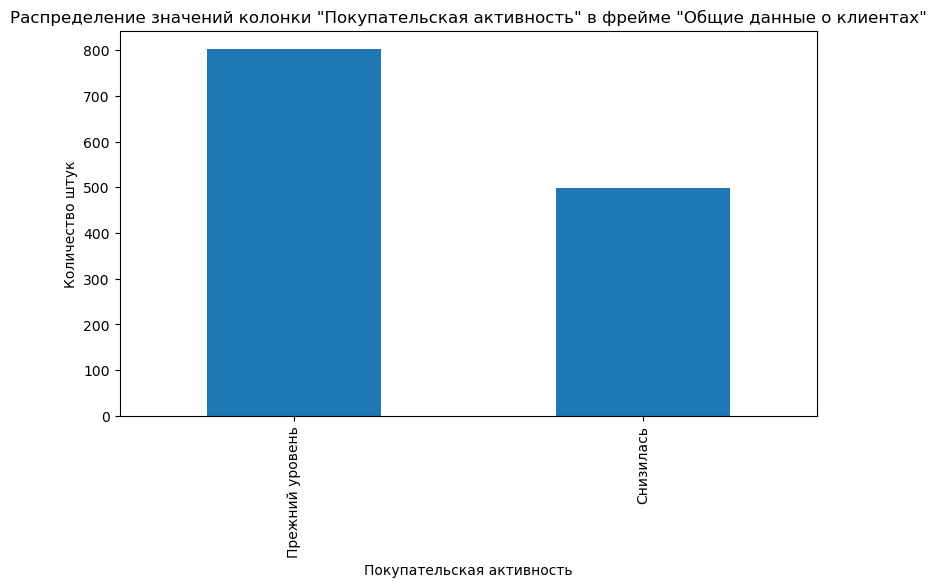

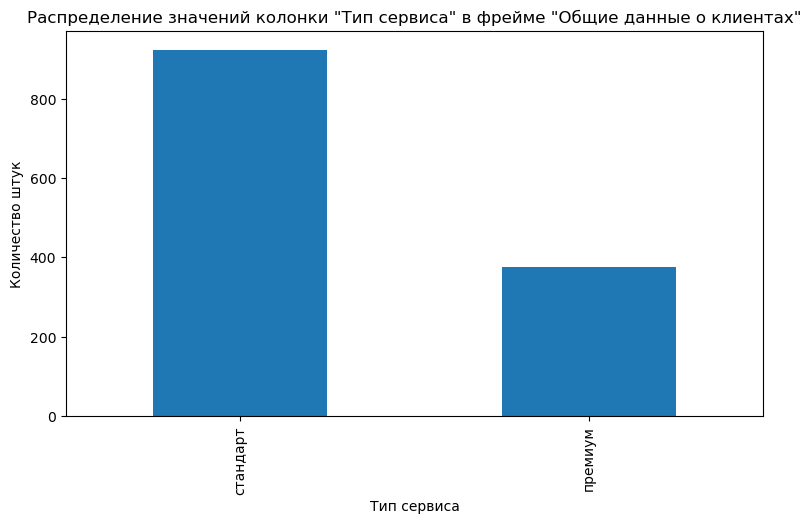

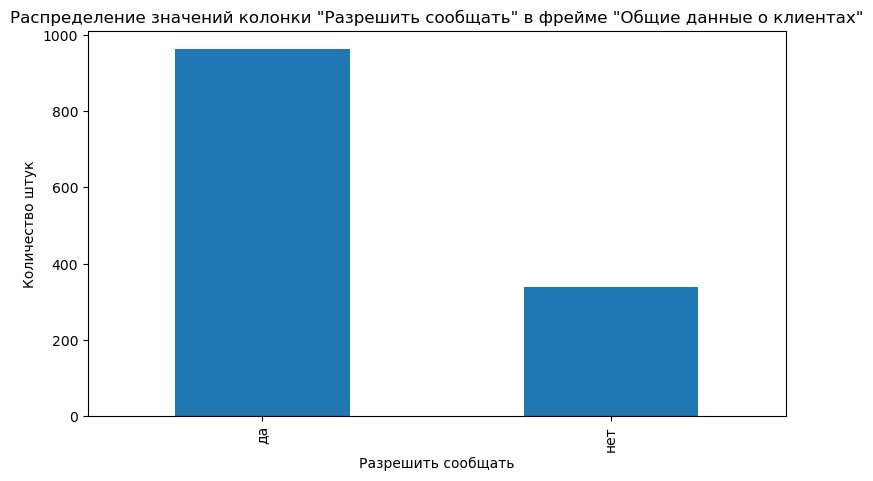

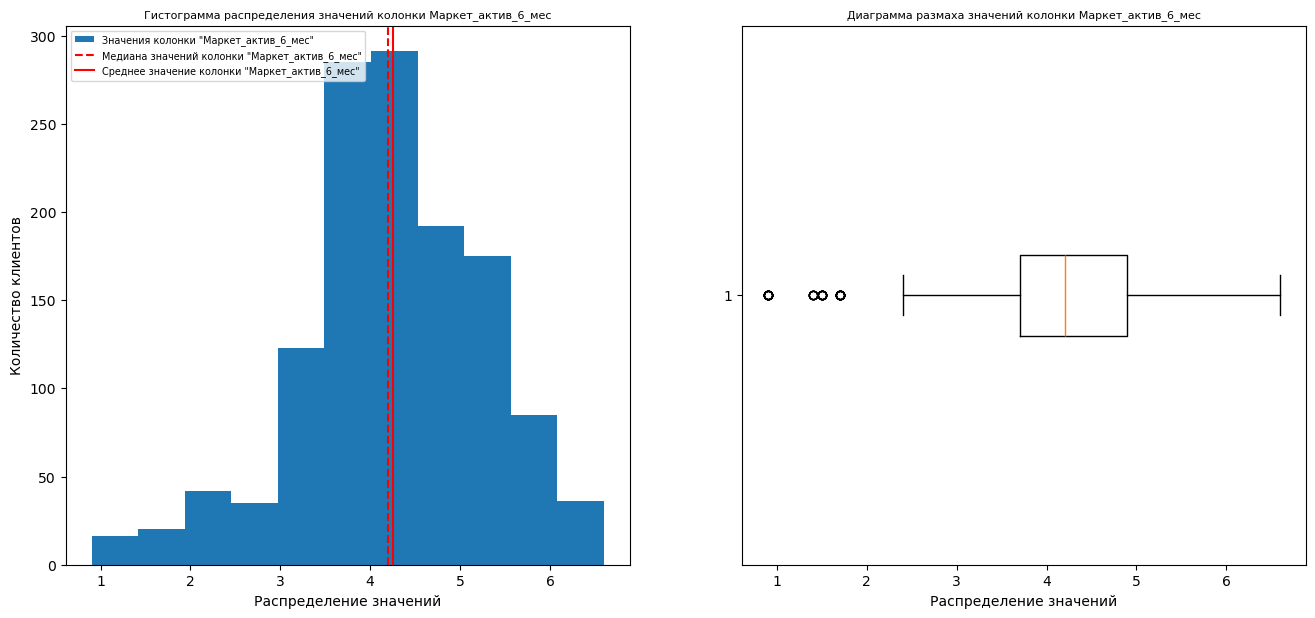

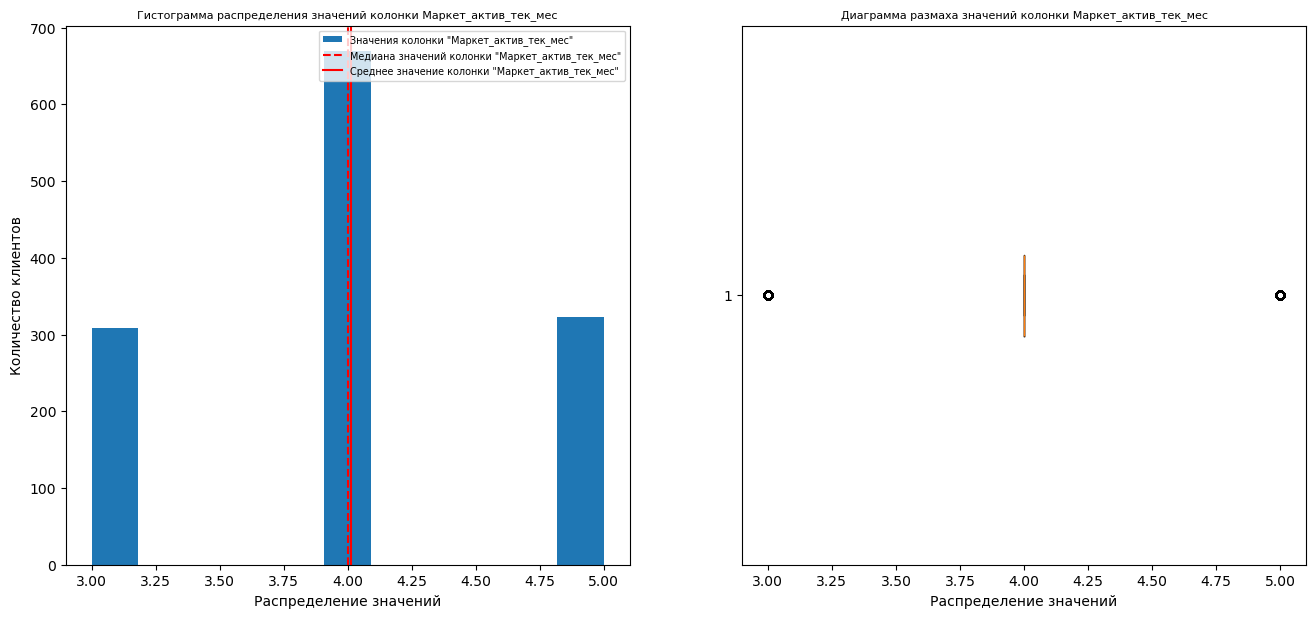

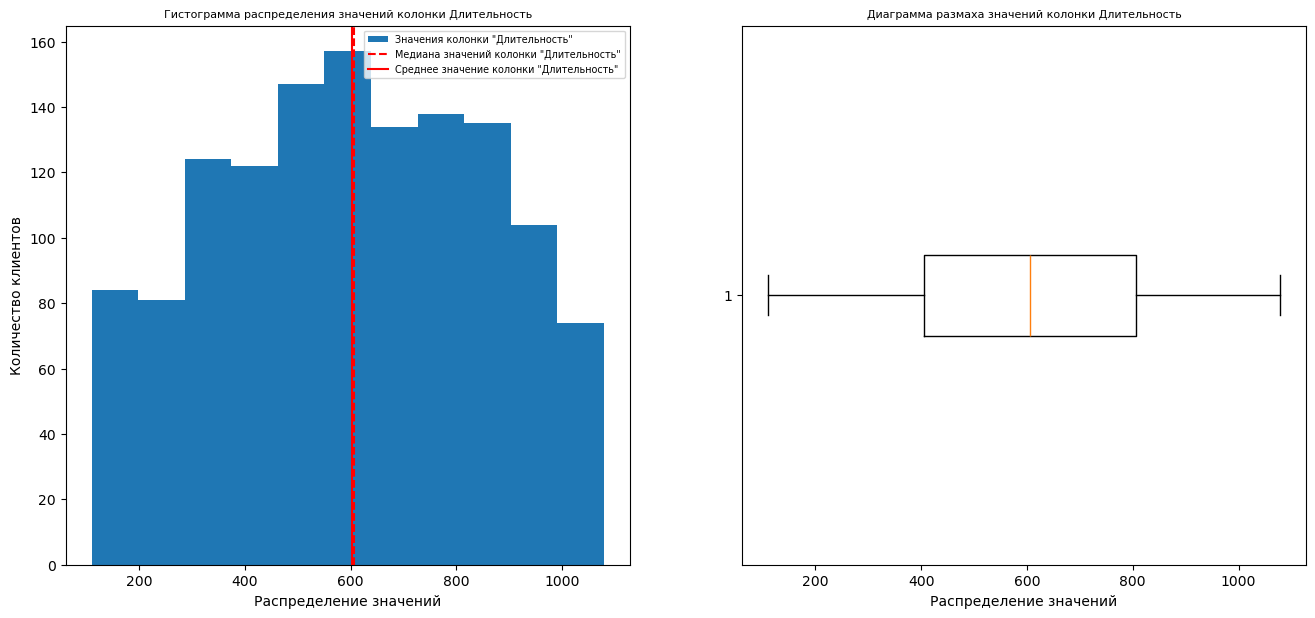

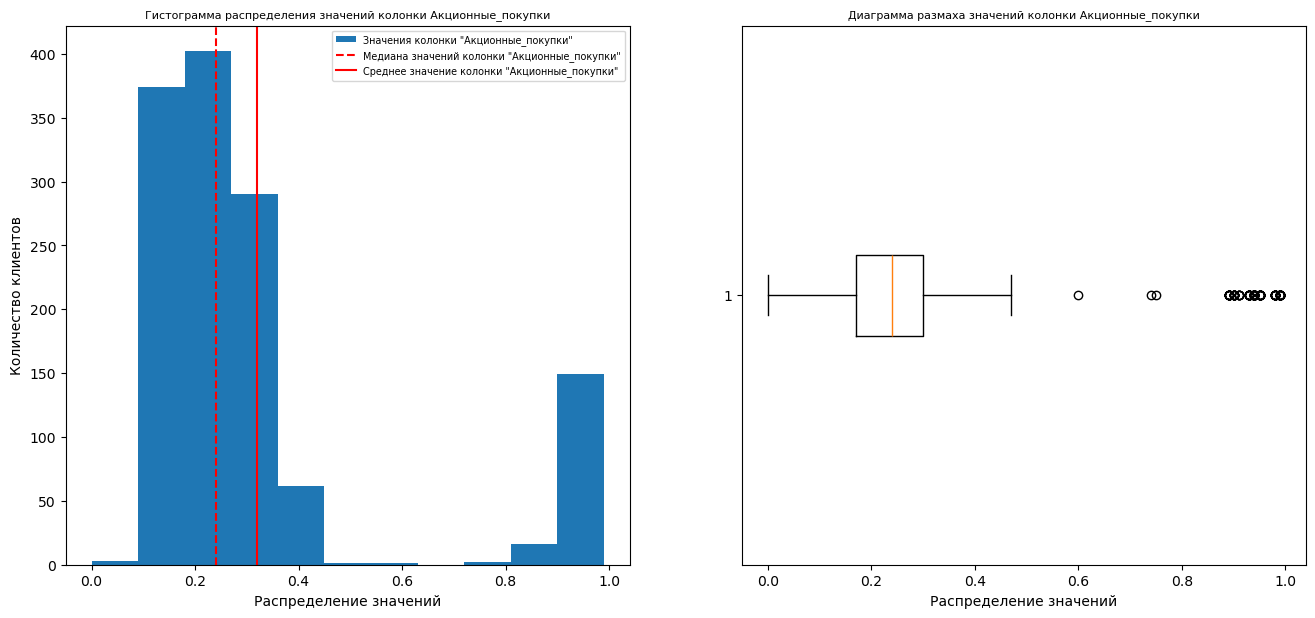

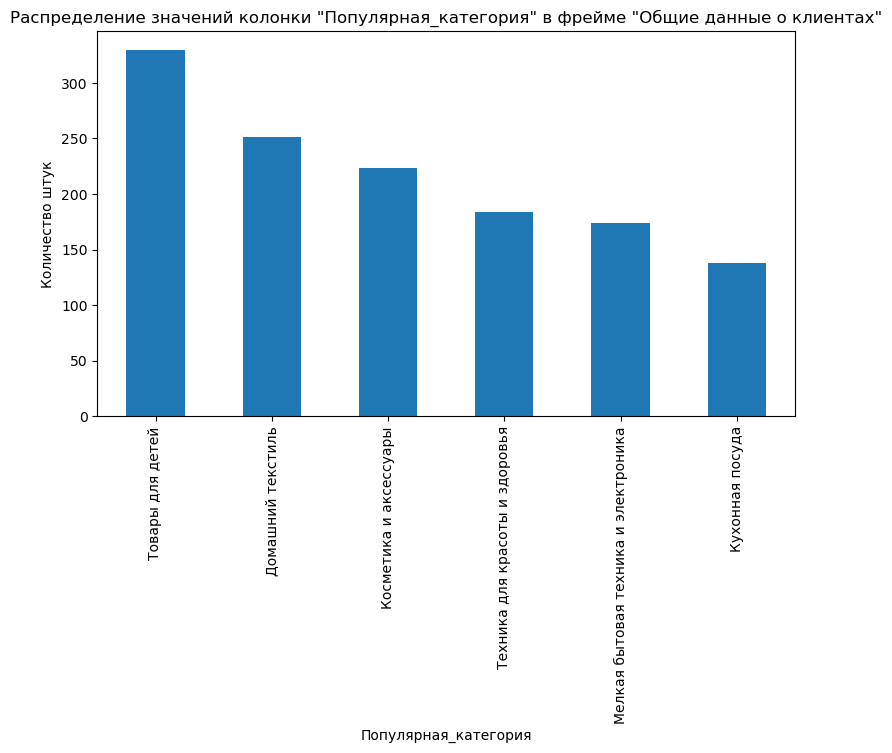

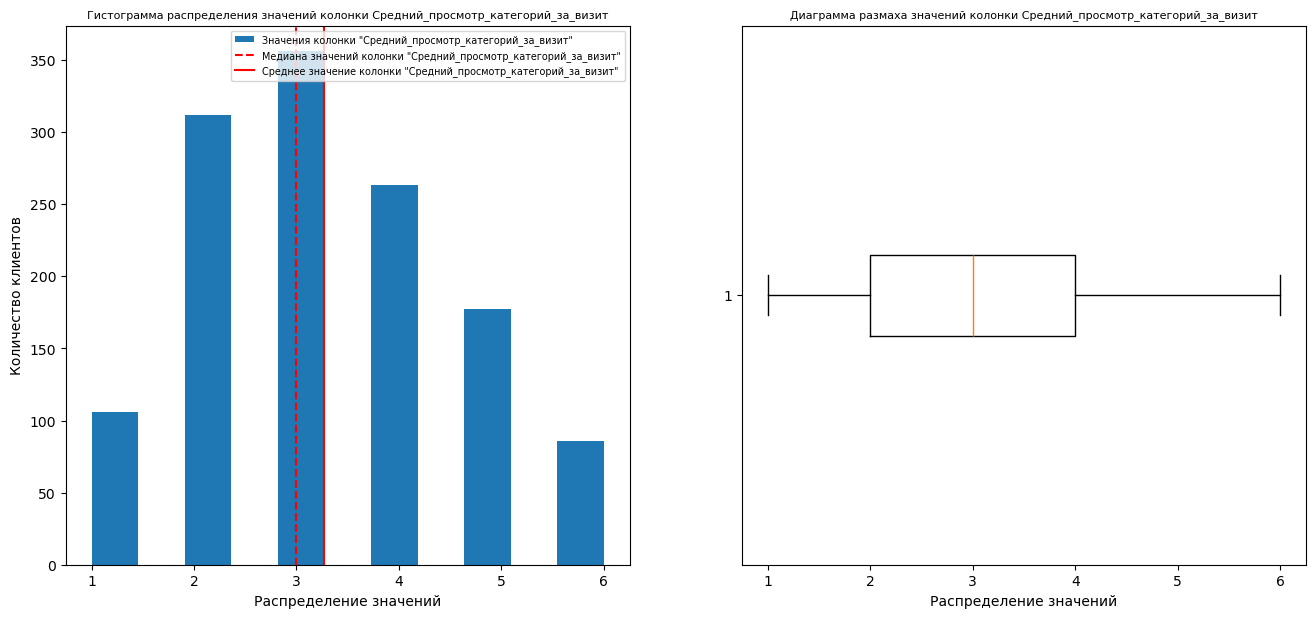

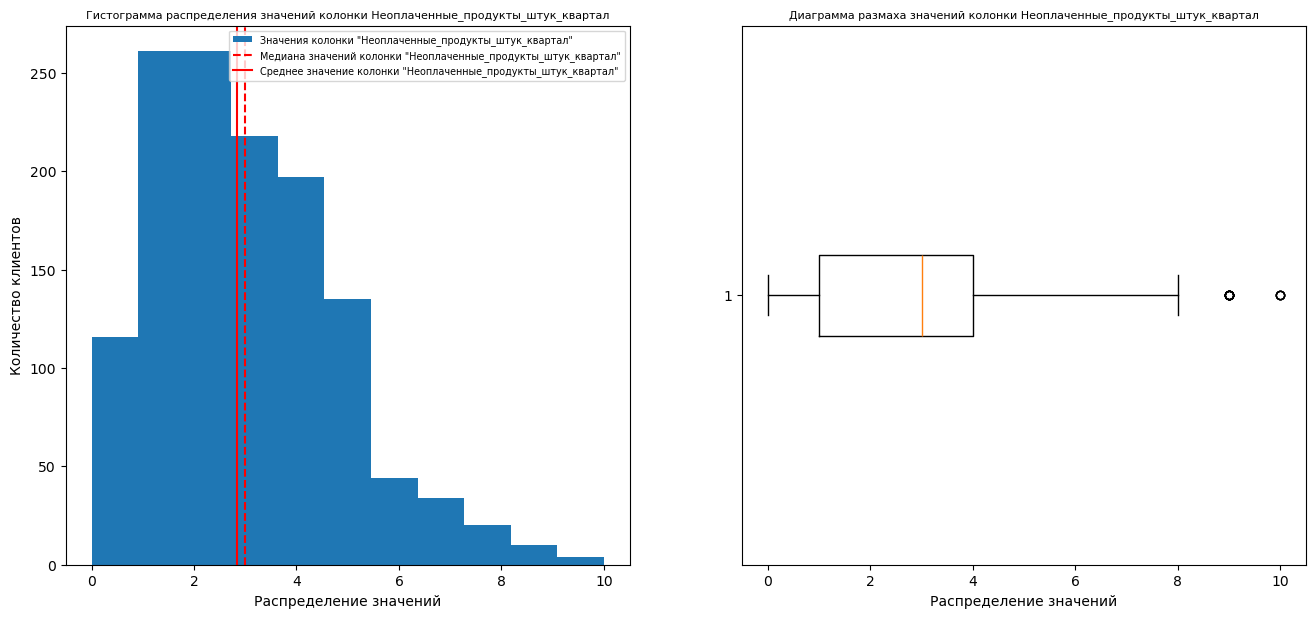

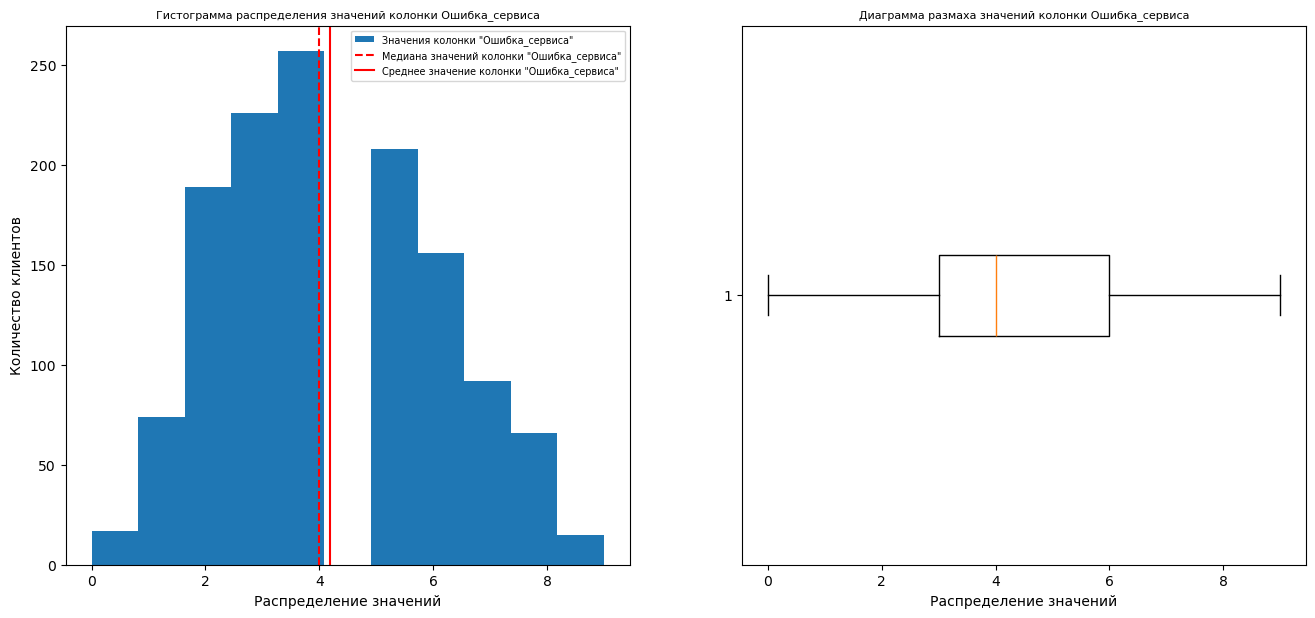

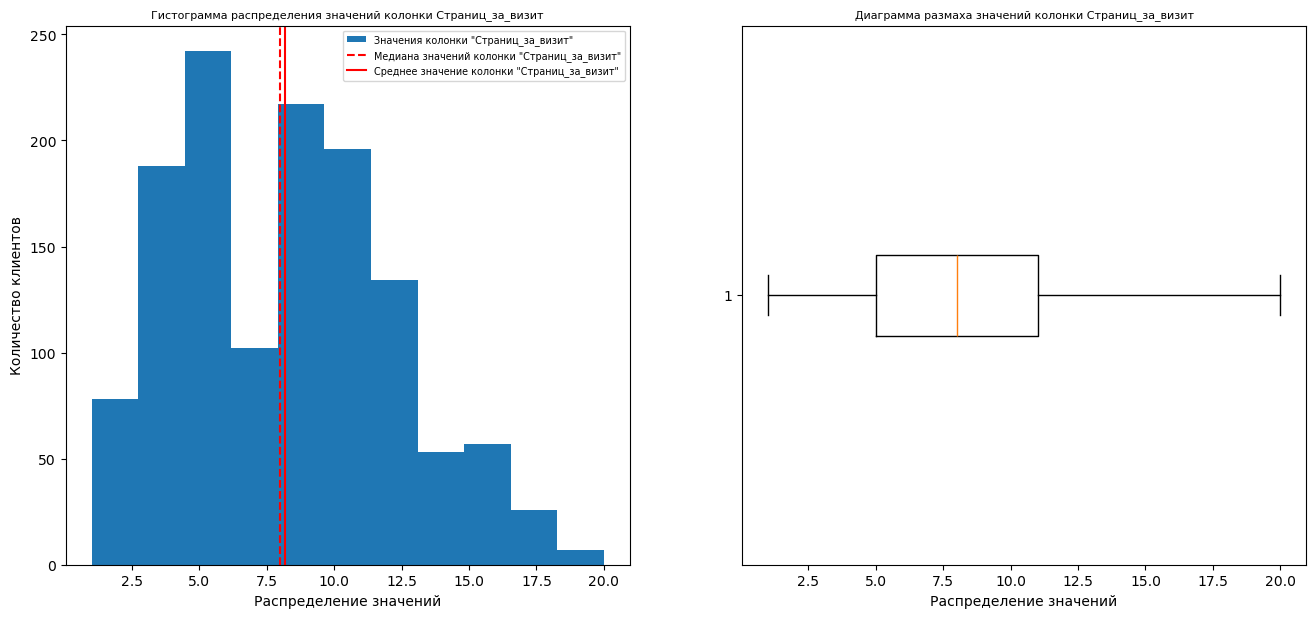

In [29]:
make_plot(clients_processed_data)

**Промежуточные выводы:**<br>
Среднестатистический клиент:
- Имеет прежний уровень покупательской активности
- Пользуется стандартным сервисом
- Разрешил сообщения
- Имеет в среднем 4 маркетинговых коммуникации в месяц
- Зарегистрирован около 600 дней на сайте
- Четверть покупок совершает по акциям
- Чаще всего покупает товары для детей
- В среднем смотрит три категории, заходя на сайт
- Имеет 2-3 товара в корзине
- Имел 4 ошибки с сервисом
- Смотрит по 5 товаров в среднем

Также стоит отметить, что на сайте выделяются две группы пользователей:
- Постоянные клиенты
- Клиенты, покупающие товары по акциям

Это хорошо видно на графике по диаграмме размаха акционных покупок. Поэтому можем преобразовать данный признак в бинарный

In [30]:
# За границу принято значение 0.6
clients_processed_data['Акционные_покупки'] = clients_processed_data['Акционные_покупки'].apply(lambda x: 1 if x > 0.6 else 0)
# Проверка
clients_processed_data['Акционные_покупки'].sample(5)

id
215861    0
216482    0
215788    0
215688    0
216299    0
Name: Акционные_покупки, dtype: int64

<span id='second_plot'>Перейдем к следующему фрейму

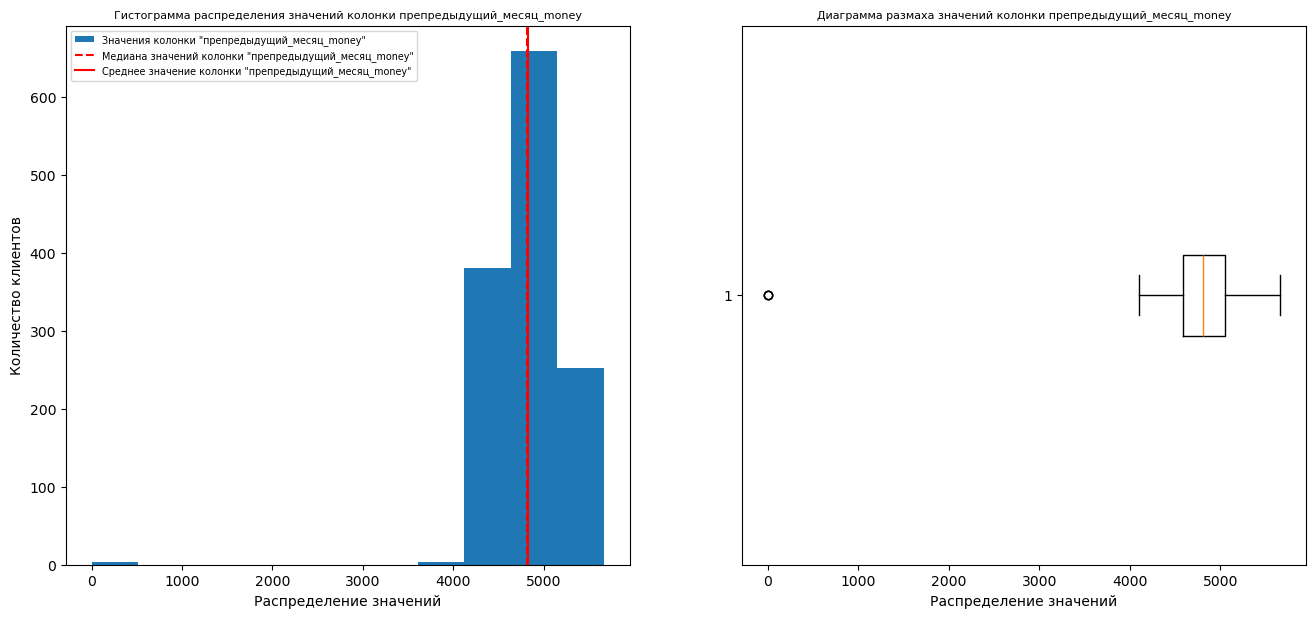

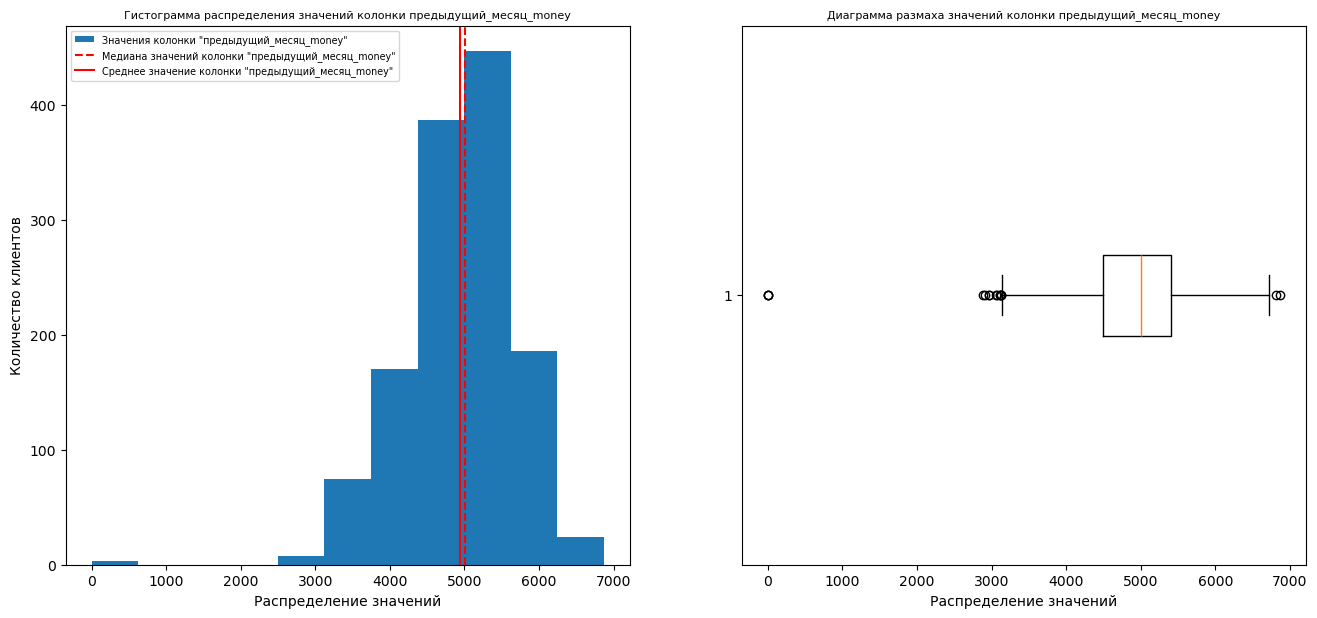

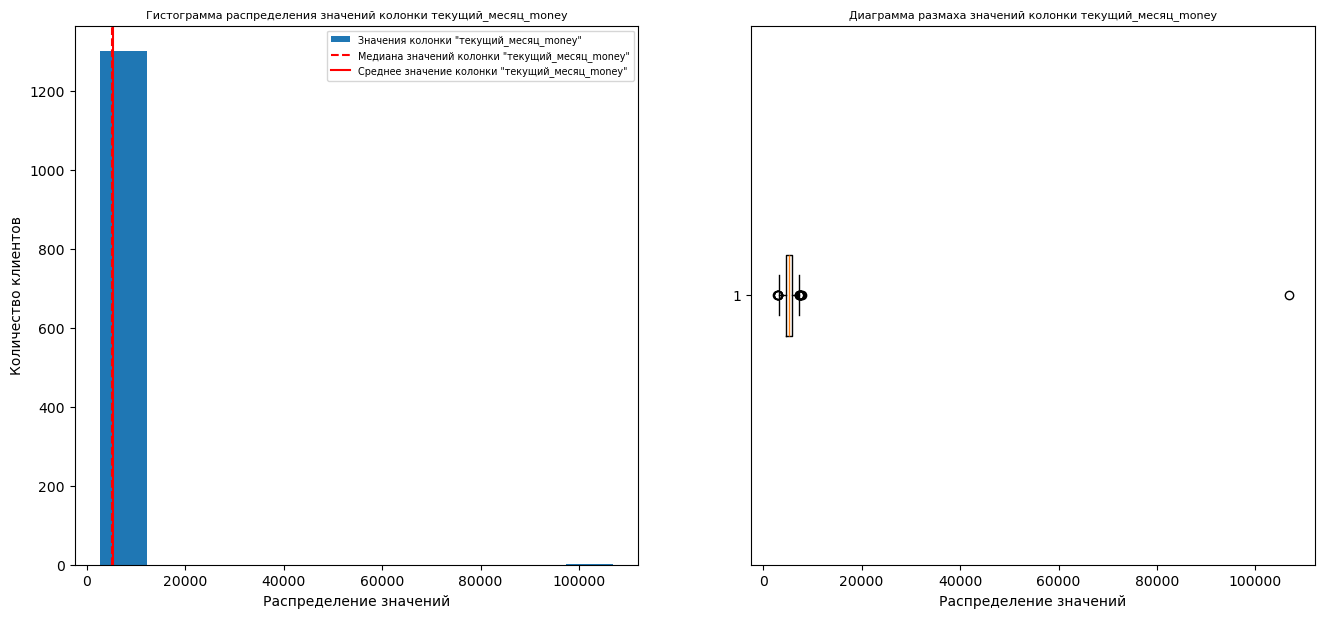

In [31]:
make_plot(money_processed_data)

Видно, что в данных по выручке есть выброс со значением более 10 тысяч. Стоит проверить данного покупателя

In [32]:
money_processed_data.query('текущий_месяц_money > 10000')

,препредыдущий_месяц_money,предыдущий_месяц_money,текущий_месяц_money
id,,,
215380,5051.0,6077.0,106862.2


Явный выброс. Стоит убрать данного клиента

In [33]:
money_processed_data = money_processed_data.query('текущий_месяц_money < 10000')
# Проверка
money_processed_data.query('текущий_месяц_money > 10000')['текущий_месяц_money'].count()

0

Также есть выбросы в виде нулевой выручке по некоторым месяцам. Таких клиентов также удалим из выборки, так как они не являются постоянными клиентами и не удовлетворяют целям текущего проекта

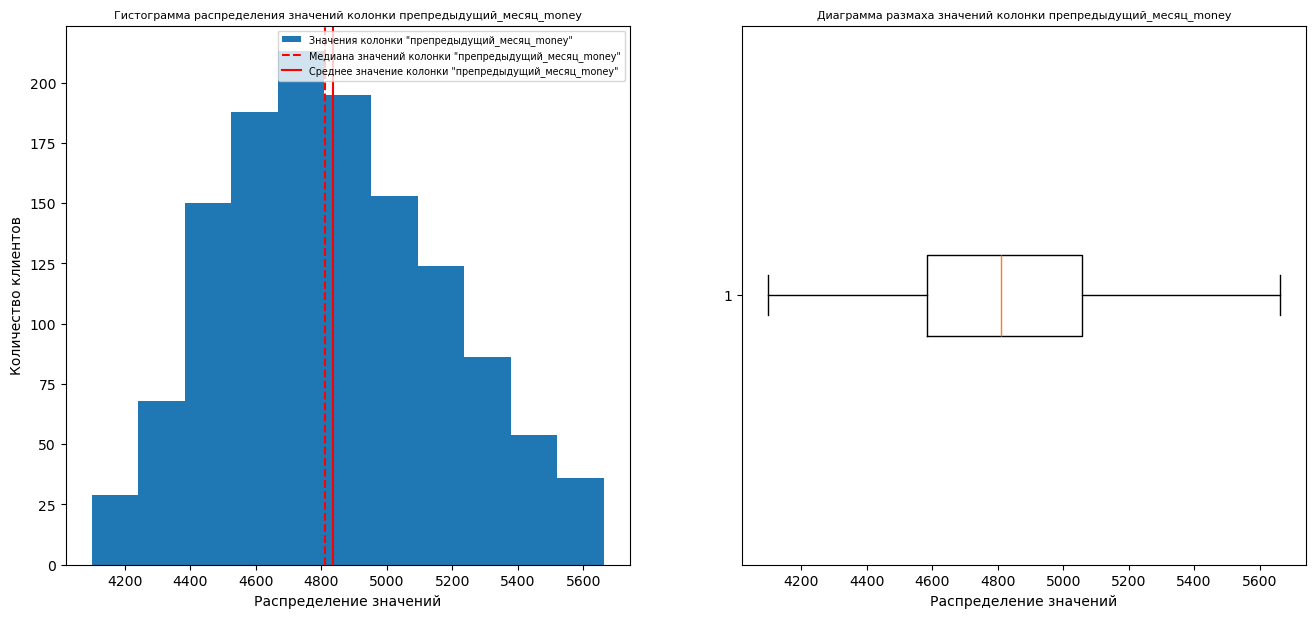

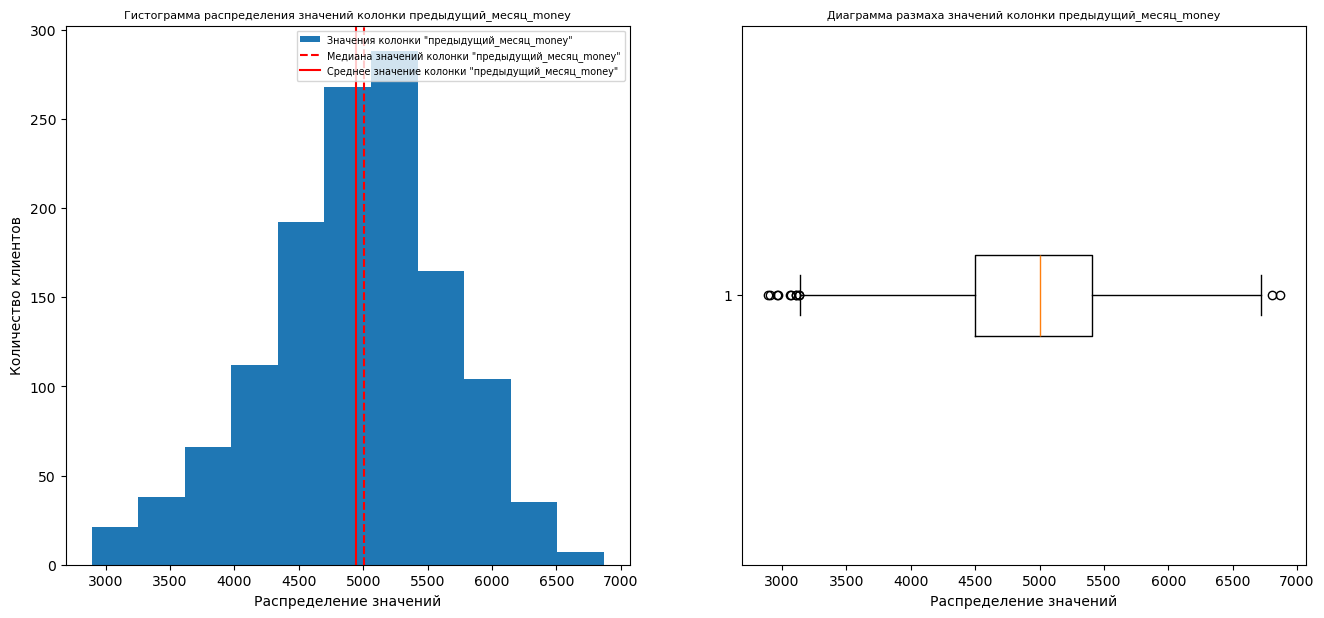

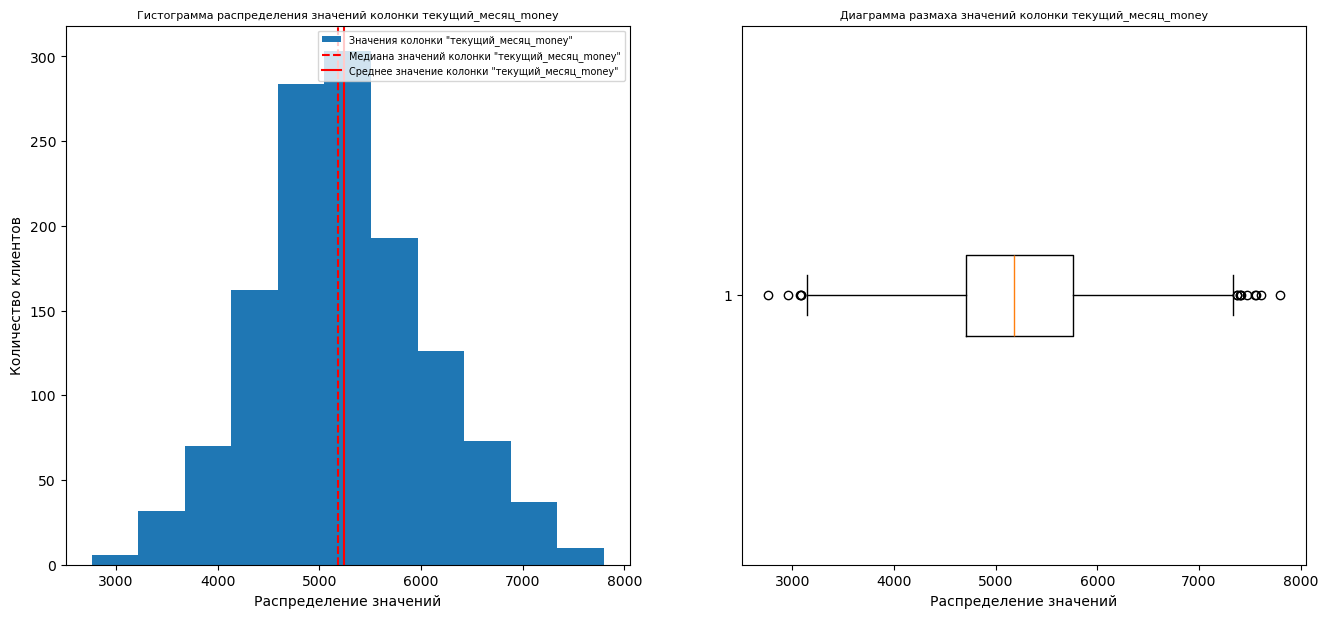

In [34]:
money_processed_data = money_processed_data.query('текущий_месяц_money != 0 and \
                                                   препредыдущий_месяц_money != 0 and \
                                                   предыдущий_месяц_money != 0')
# Проверка
make_plot(money_processed_data)

Мы избавились от выбросов. Далее объединение должно происходить по id, имеющимся в данном фрейме<br>
**Промежуточный вывод:**<br>
- В среднем выручка сайта увеличиливалась на протящении последних трех месяцев
- За текущий месяц компания получила в среднем 5200 с одного клиента

Теперь к следующему фрейму

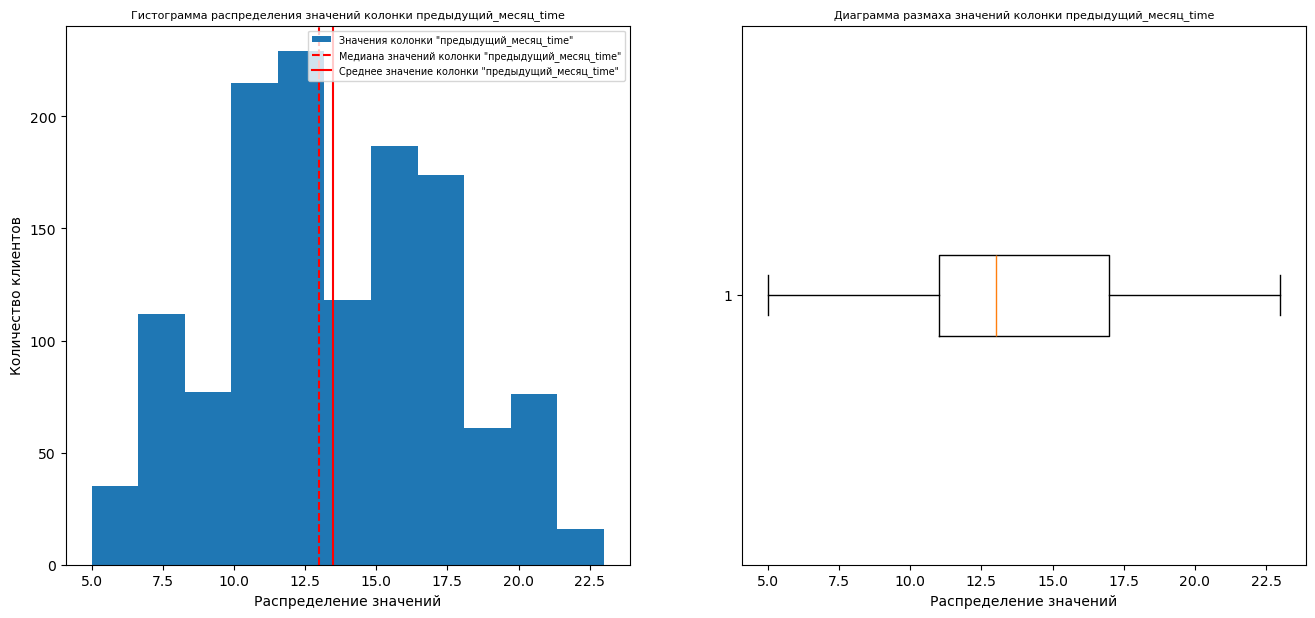

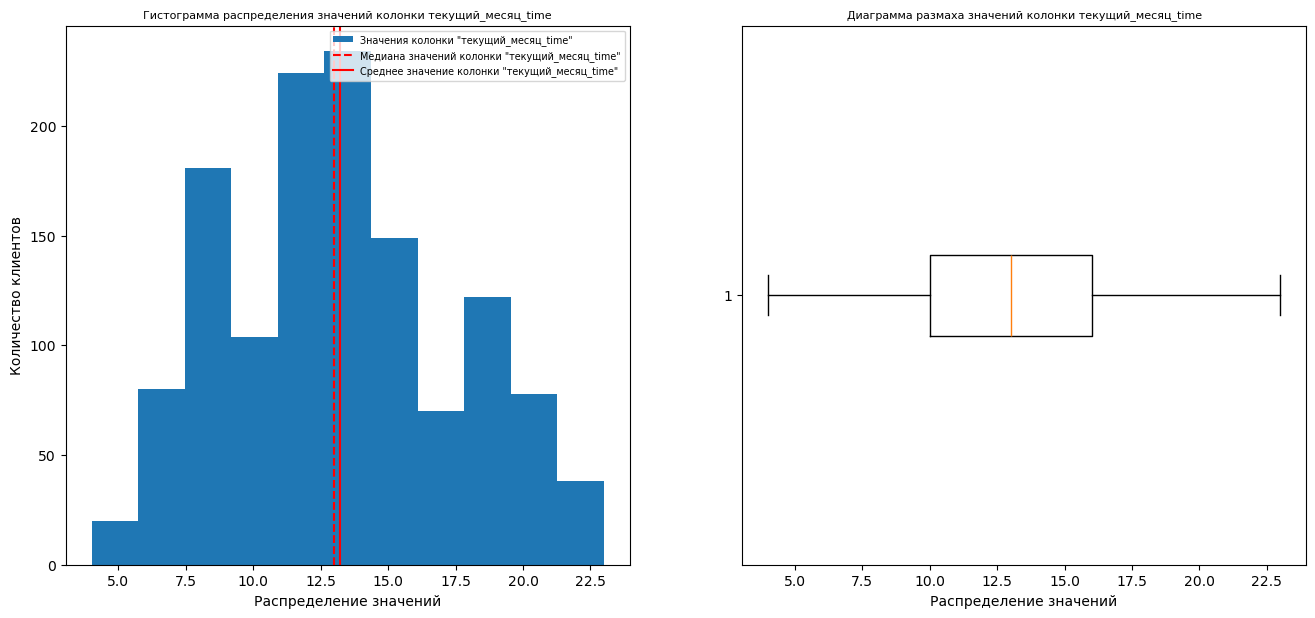

In [35]:
make_plot(time_processed_data)

Выбросов нет.<br>
**Промежуточный вывод:**
- Клиенты стали проводить меньше времени на сайте
- В текущем месяце клиент находился на сайте в среднем 13 минут

Последний фрейм

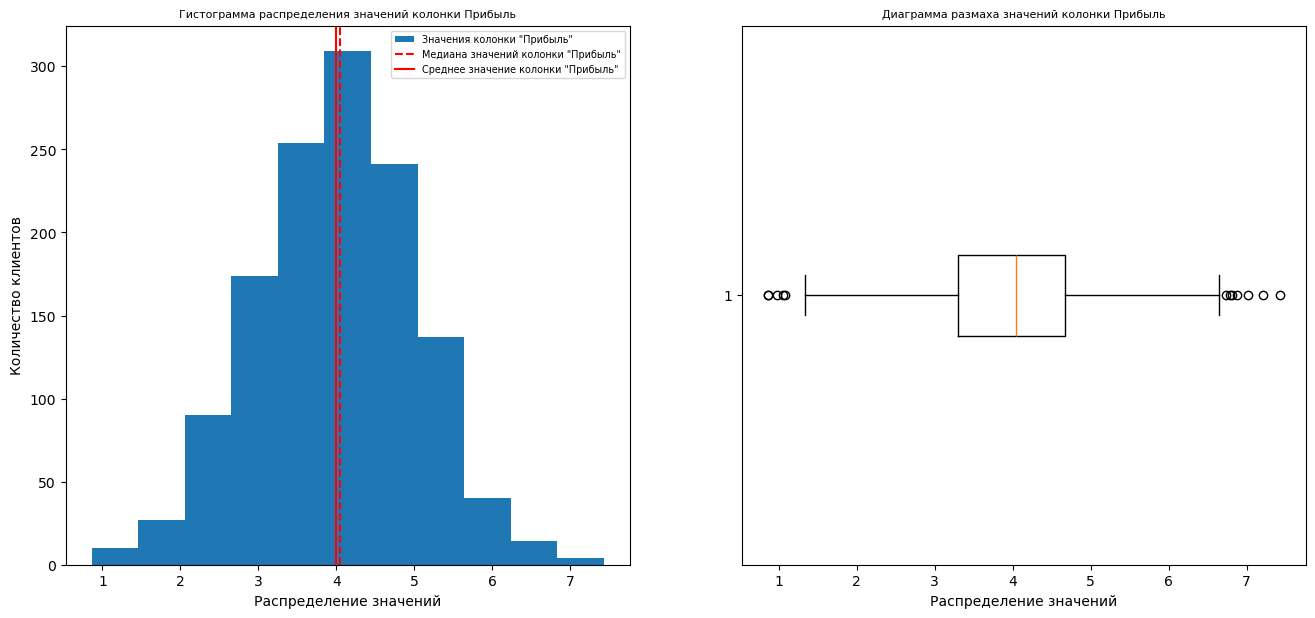

In [38]:
make_plot(mean_money_processed_data)

Никаких преобразований не требуется

**Итоговый вывод:**
Среднестатистический клиент:

- Имеет прежний уровень покупательской активности
- Пользуется стандартным сервисом
- Разрешил сообщения
- Имеет в среднем 4 маркетинговых коммуникации в месяц
- Зарегистрирован около 600 дней на сайте
- Четверть покупок совершает по акциям
- Чаще всего покупает товары для детей
- В среднем смотрит три категории, заходя на сайт
- Имеет 2-3 товара в корзине
- Имел 4 ошибки с сервисом
- Смотрит по 5 товаров в среднем

Также стоит отметить, что на сайте выделяются две группы пользователей:
- Постоянные клиенты
- Клиенты, покупающие товары по акциям

В среднем выручка сайта увеличиливалась на протящении последних трех месяцев<br>
За текущий месяц компания получила в среднем 5200 с одного клиента

Клиенты стали проводить меньше времени на сайте<br>
В текущем месяце клиент находился на сайте в среднем 13 минут

В среднем магазин получает прибыль в 4 юнита с клиента

## Объединение таблиц в общий фрейм

Объединим фрейм `Общие данные о клиентах` с фреймами `Данные о выручке с клиентов` и `Данные о времени клиентов`. Объединять будем по `id` клиентов, содержащимся во втором фрейме, так как в данном фрейме были исключены несколько выбросов

In [41]:
# Никаких параметров указывать не будем, так как подходят стандартные
total_clients_data = money_processed_data.join([clients_processed_data, time_processed_data])
# Проверка, кол-во строк должно быть равно кол-ву строк фрейма money_processed_data
if total_clients_data.shape[0] == money_processed_data.shape[0]:
   print(f'Объединение успешно, итоговый фрейм содержит {total_clients_data.shape[0]} объектов и {total_clients_data.shape[1]} признаков')
   display(total_clients_data.sample(5))
else:
   print('Ошибка оюъединения. Размеры исходного и фактического фреймов не совпадают')

Объединение успешно, итоговый фрейм содержит 1296 объектов и 17 признаков


,препредыдущий_месяц_money,предыдущий_месяц_money,текущий_месяц_money,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_time,текущий_месяц_time
id,,,,,,,,,,,,,,,,,
215652,4940.0,5567.0,6166.3,Снизилась,стандарт,да,5.6,3,805,1,Домашний текстиль,2,1,3,4,12,11
216454,4946.0,4332.5,3930.8,Прежний уровень,премиум,да,4.4,5,929,0,Кухонная посуда,5,1,6,7,19,22
216019,4711.0,3670.0,4702.2,Прежний уровень,стандарт,да,5.2,4,746,0,Техника для красоты и здоровья,3,3,4,9,15,16
216530,5118.0,5388.0,5280.1,Прежний уровень,стандарт,нет,4.9,3,362,0,Товары для детей,4,1,5,12,17,15
215404,4449.0,3788.0,4867.0,Снизилась,стандарт,да,2.4,3,699,1,Домашний текстиль,4,1,2,3,12,13


Проверим, есть ли пустые значения в колонках

In [42]:
total_clients_data.isna().sum()

препредыдущий_месяц_money              0
предыдущий_месяц_money                 0
текущий_месяц_money                    0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
предыдущий_месяц_time                  0
текущий_месяц_time                     0
dtype: int64

Пустот нет. Объединение успешно

## Коррелиационный анализ данных

<span id='step-5'>Выведем корреляционную матрицу для отбора признаков

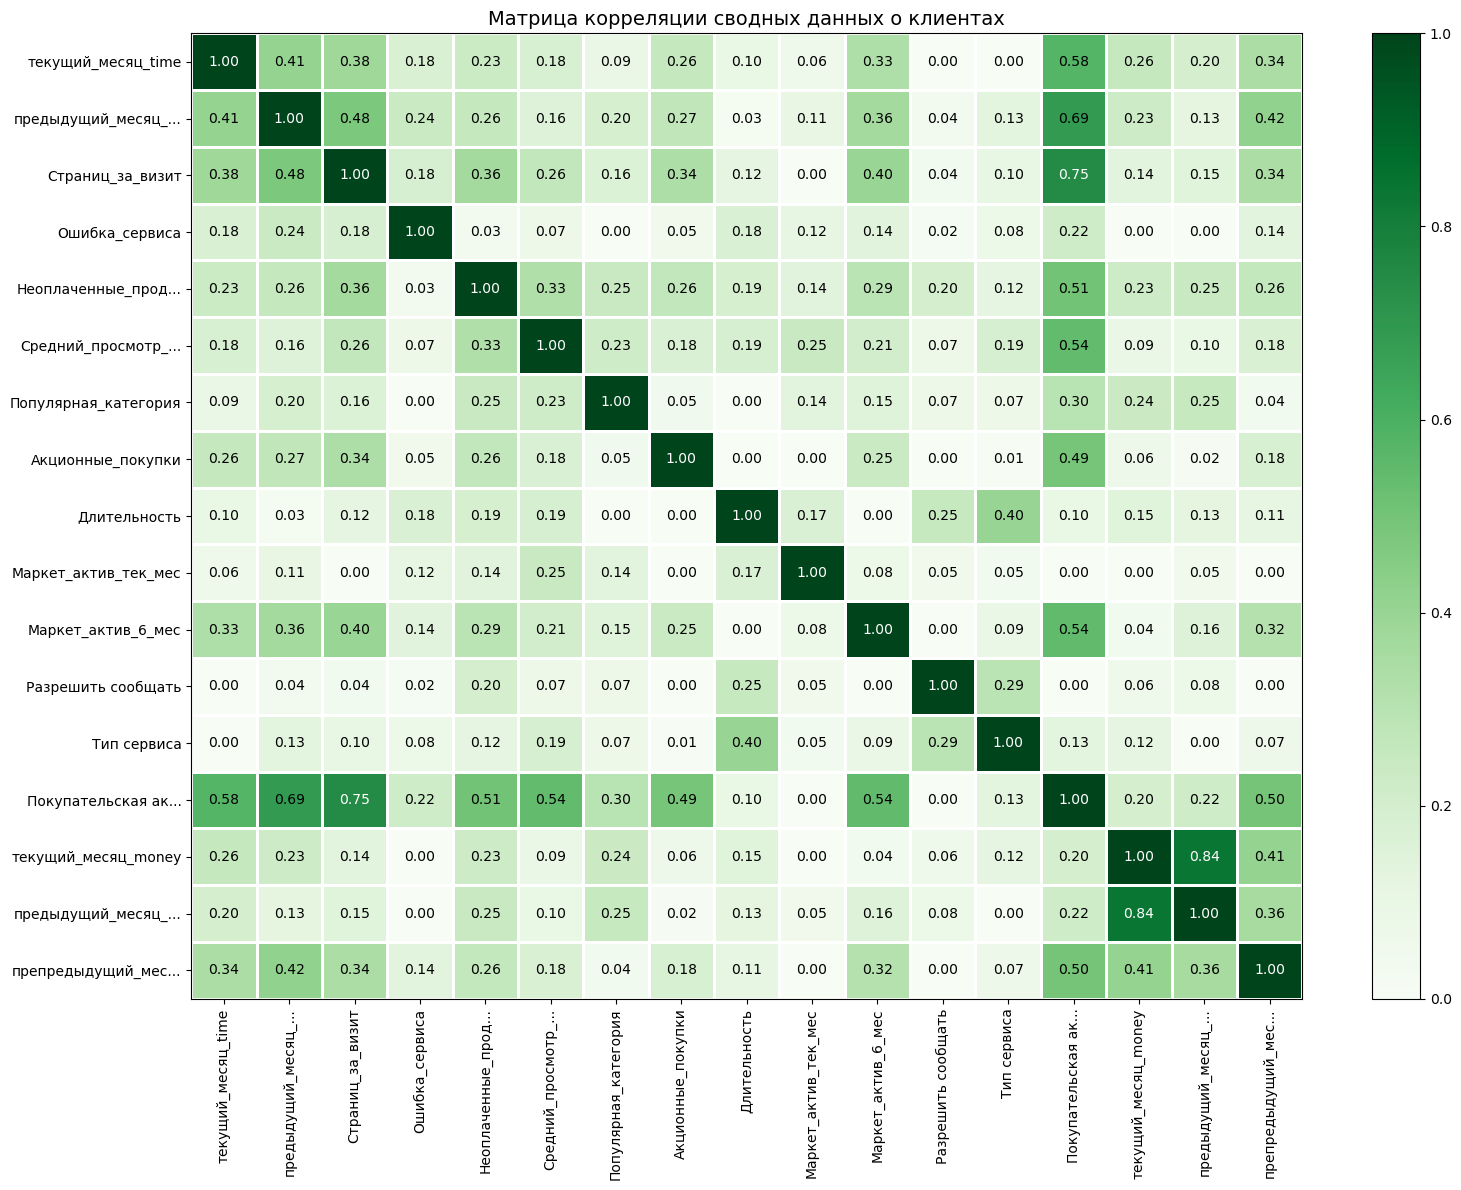

In [44]:
phik_overview = phik_matrix(total_clients_data,
                            interval_cols=[x for x in total_clients_data.columns if total_clients_data[x].dtype != 'object'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Greens',
    title=r'Матрица корреляции сводных данных о клиентах',
    figsize=(16, 12)
) 

По данному графику видно, что целевой признак `Покупательская активность` коррелирует со следующими признаками (расположены в порядке убывания коэффициента корреляции):
- Количество просматриваемых страниц за визит `Страниц_за_визит`
- Время, проведенное на сайте в предыдущем месяце `предыдущий_месяц_time`
- Время, проведенное на сайте в текущем месяце `текущий_месяц_time`

Мультиколлинеарность наблюдается у признаков `предыдущий_месяц_money` и `текущий_месяц_money`. Из всех "финансовых" признаков с целевым признаком больше коррелирует `препредыдущий_месяц_money` - остальные два можем заменить на отношение признака к указанному (получим относительное изменение выручки)

In [45]:
total_clients_data['текущий_месяц_money'] = \
                    total_clients_data['текущий_месяц_money'] / total_clients_data['предыдущий_месяц_money']

total_clients_data['предыдущий_месяц_money'] = \
                    total_clients_data['предыдущий_месяц_money'] / total_clients_data['препредыдущий_месяц_money']

**Вывод:**
- Были выявлены признаки наиболее коррелирующие с целевым
- Была устранена мультиколлинеарность за счет преобразования признаков

## Построение пайплайнов

Построим паплайны для выбора наиболее точной модели.<br>
Будем использовать метрику Recall, так как необходимо верно предсказать как можно больше людей со снижающейся покупательской активностью

Разобьем данные на тренировочную и валидационные выборки. Так как у нас есть диспропорция в целевом признаке, будем использовать стратификацию

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    total_clients_data.drop('Покупательская активность', axis=1),
    total_clients_data['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify=total_clients_data['Покупательская активность']
)
if X_train.shape[0] + X_test.shape[0] == total_clients_data.shape[0]:
    print(f'Размер тренировочной выборки: {X_train.shape}, тестовой - {X_test.shape}')
else: 
    print('Есть ошибка в разбиении. Данные несоразмерно поделены')

Размер тренировочной выборки: (972, 16), тестовой - (324, 16)


<span id='preproc'>Закодируем целевой признак

In [48]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print('Значения кодировщика: ', dict(zip(le.classes_, le.transform(le.classes_))))
y_test = le.transform(y_test)

Значения кодировщика:  {'Прежний уровень': 0, 'Снизилась': 1}


Создадим списки с наименованиями колонок для их предобработки

In [49]:
qual_ohe_cols = ['Популярная_категория']
qual_ord_cols = ['Тип сервиса', 'Разрешить сообщать', 'Акционные_покупки']
quan_cols = ['препредыдущий_месяц_money', 'предыдущий_месяц_money', 'текущий_месяц_money', \
             'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', \
             'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц_time',\
             'текущий_месяц_time']

<span id='preproc'>Создадим пайплан для кодирования качественных признаков и масштабирования количественных признаков

In [50]:
# Пайплайн для кодировки данных с помощью OrdinalEncoder
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)
# Полный пайплайн для предобработки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore', sparse=False), qual_ohe_cols),
        ('ord', ord_pipe, qual_ord_cols),
        ('quan', MinMaxScaler(), quan_cols)
    ], 
    remainder='passthrough'
)

<span id='model'>Создаём итоговый пайплайн

In [51]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

<span id='best-model'>Задаем параметры поиска лучшего сочетания параметров модели.<br>
Для качественных признаков мы попробуем OrdinalEncoder и OneHotEncoder<br>
Для количественных - StandardScaler, MinMaxScaler, RobustScaler и без масштабирования

Будем измерять точность четырех различных моделей: DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, SVC

In [52]:
preprocessor__quan = [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']

params = [
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(1, 21),
        'preprocessor__quan': preprocessor__quan
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 21),
        'model__min_samples_split': range(2, 21),
        'model__min_samples_leaf': range(1, 21),
        'preprocessor__quan': preprocessor__quan
    },
    {
        'model': [SVC(random_state=RANDOM_STATE)],
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': np.arange(0.05, 1, 0.05),
        'preprocessor__quan': preprocessor__quan

    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__penalty': [None, 'l2', 'l1', 'elasticnet'],
        'preprocessor__quan': preprocessor__quan
    }
]

Запустим RandomizedSearchCV для поиска лучшего сочетания параметров

In [53]:
# Технический блок, чтобы не возникало ошибок на пол экрана
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [54]:
search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=params, 
    scoring='recall', 
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train)

Выведем описание лучшей модели

In [55]:
print('Метрика recall для лучшей модели:\n', search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', search.best_estimator_) 

Метрика recall для лучшей модели:
 0.7842882882882882

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   Simpl

<span id='model-results'>Посчитаем метрику Recall на тестовой выборке

In [56]:
best_pipeline = search.best_estimator_
print('Recall метрика на тестовой выборке составляет:', recall_score(y_test, best_pipeline.predict(X_test)))

Recall метрика на тестовой выборке составляет: 0.7398373983739838


**Вывод:** наиболее точной моделю стала модель DecisionTreeClassifier с глубиной 16, минимум 11 объектов для деления, масштабирвоанием методом RobustScaler количественных признаков. При кросс-валидации данная модель показала качество 0.78439, на тестовой - 0.73984

## Анализ важности признаков

Для интерпретации модели используем метод TreeExplainer библиотеки shap

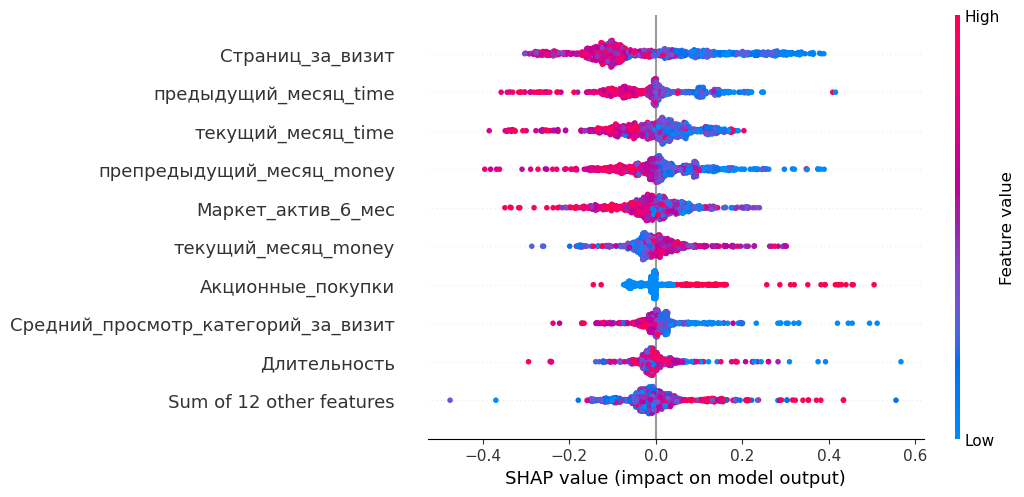

In [58]:
columns = (search.best_estimator_['preprocessor']
                 .transformers_[0][1]
                 .get_feature_names_out(qual_ohe_cols)
                 .tolist()) + qual_ord_cols + quan_cols

X_train_ = pd.DataFrame(
    search.best_estimator_['preprocessor'].transform(X_train),
    columns=columns
)
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'], X_train_)
shap_values = explainer(X_train_)

shap.plots.beeswarm(shap_values[:,:,1])

<span id='leak'>**Вывод:**<br>
Малозначимыми признаками для модели оказались следующие признаки:
- Популярная_категория
- Тип сервиса
- Разрешить сообщать
- предыдущий_месяц_money
- Маркет_актив_тек_мес
- Ошибка_сервиса
- Неоплаченные продукты штук квартал

Больше всего на модель влияют следующие признаки:
- Станиц за визит
- Предыдущий_месяц_time
- текущий_месяц_time
- препредыдущий_месяц_money
- Маркет_активность_6_мес
- текущий_месяц_money
- Средний_просмотр_категорий_за_визит
- Акционные_покупки
- Длительность

Приметами снижения покупательской активности у клиента можно вынести следующие признаки:
- Малое количество просмотренных за визит страниц
- Малое времяпровождение на сайте
- Низкие траты на покупки
- Малая маркет активность
- Большое число акционных покупок
- Малое число просмотров категорий за визит

## Сегментация покупателей

<span id='group'>Сегментация покупателей будет произведена по признаку "покупка только техники, то есть товары с длинным жизненным циклом". Для начала объединим обобщенные данные о клиентах с их прибыльностью

In [60]:
group_data = (
    total_clients_data.query('Популярная_категория == "Мелкая бытовая техника и электроника"')
                      .join(mean_money_processed_data)
)
# Проверка
if total_clients_data.query('Популярная_категория == "Мелкая бытовая техника и электроника"').shape[0] == group_data.shape[0]:
    print(f'Объединение успешно, итоговый фрейм содержит {group_data.shape[0]} строк и {group_data.shape[1]} столбцов')
    display(group_data.sample(5, random_state=RANDOM_STATE))
    group_data.name = 'Данные о сегменте'
else:
    print('Есть ошибка в объединении')

Объединение успешно, итоговый фрейм содержит 174 строк и 18 столбцов


,препредыдущий_месяц_money,предыдущий_месяц_money,текущий_месяц_money,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_time,текущий_месяц_time,Прибыль
id,,,,,,,,,,,,,,,,,,
216513,5072.0,0.970722,1.000264,Прежний уровень,стандарт,да,4.1,4,559,0,Мелкая бытовая техника и электроника,4,2,1,7,17,14,2.60
216216,5092.0,1.169678,1.147549,Прежний уровень,премиум,да,3.9,4,324,0,Мелкая бытовая техника и электроника,3,3,5,4,15,14,3.57
215798,4883.0,0.953615,0.985762,Снизилась,стандарт,да,4.3,5,623,0,Мелкая бытовая техника и электроника,2,2,8,12,15,16,5.06
215864,4774.0,1.042731,1.061631,Прежний уровень,стандарт,да,5.8,4,490,0,Мелкая бытовая техника и электроника,2,4,5,16,11,12,2.97
216405,5663.0,0.818824,0.836273,Прежний уровень,стандарт,да,4.0,4,436,0,Мелкая бытовая техника и электроника,4,1,6,9,17,21,3.30


<span id='group-plot'>Проверим распределение важных для модели признаков, а также признака "Прибыль"

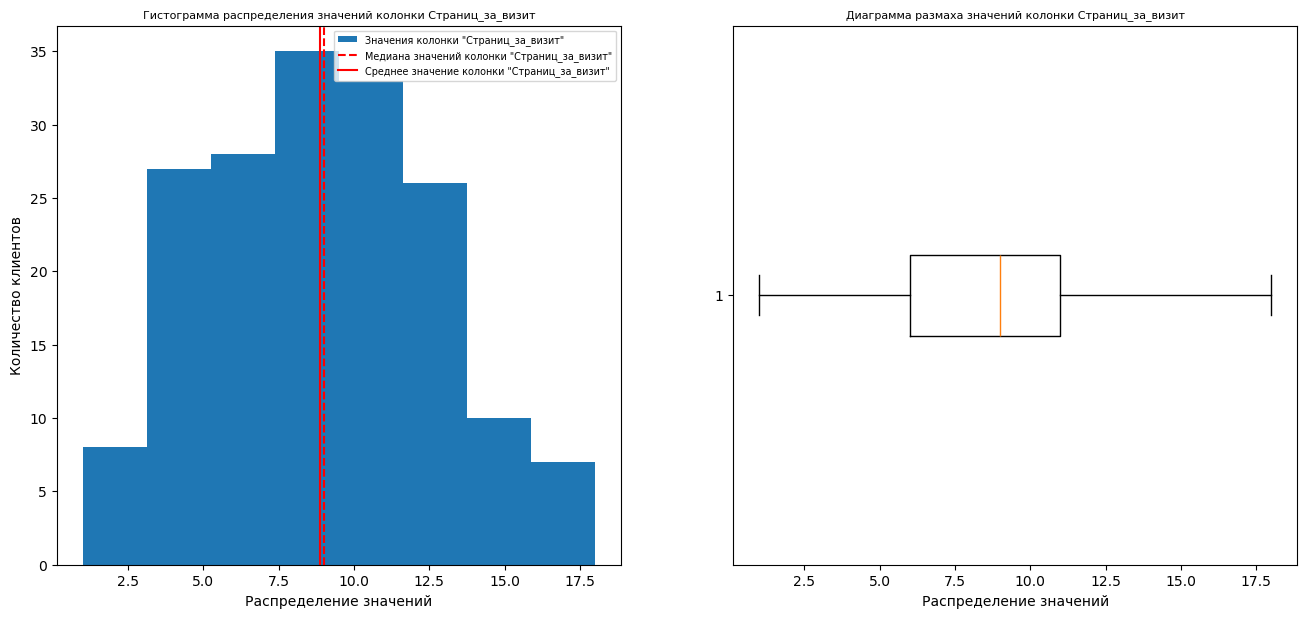

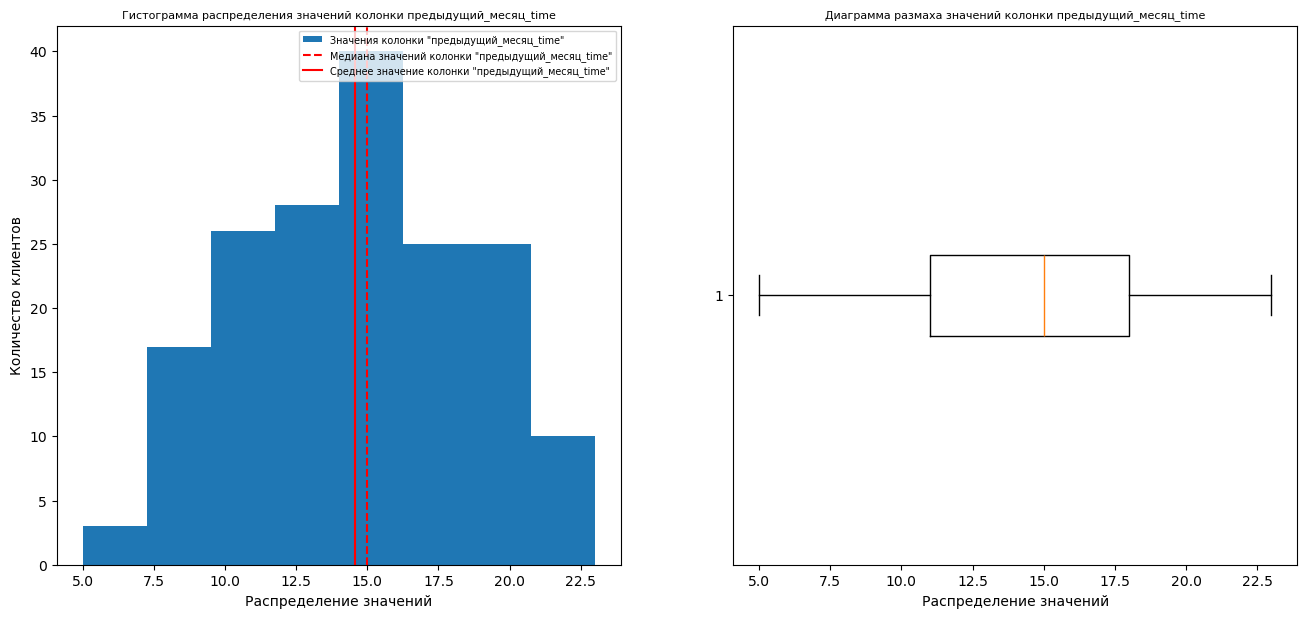

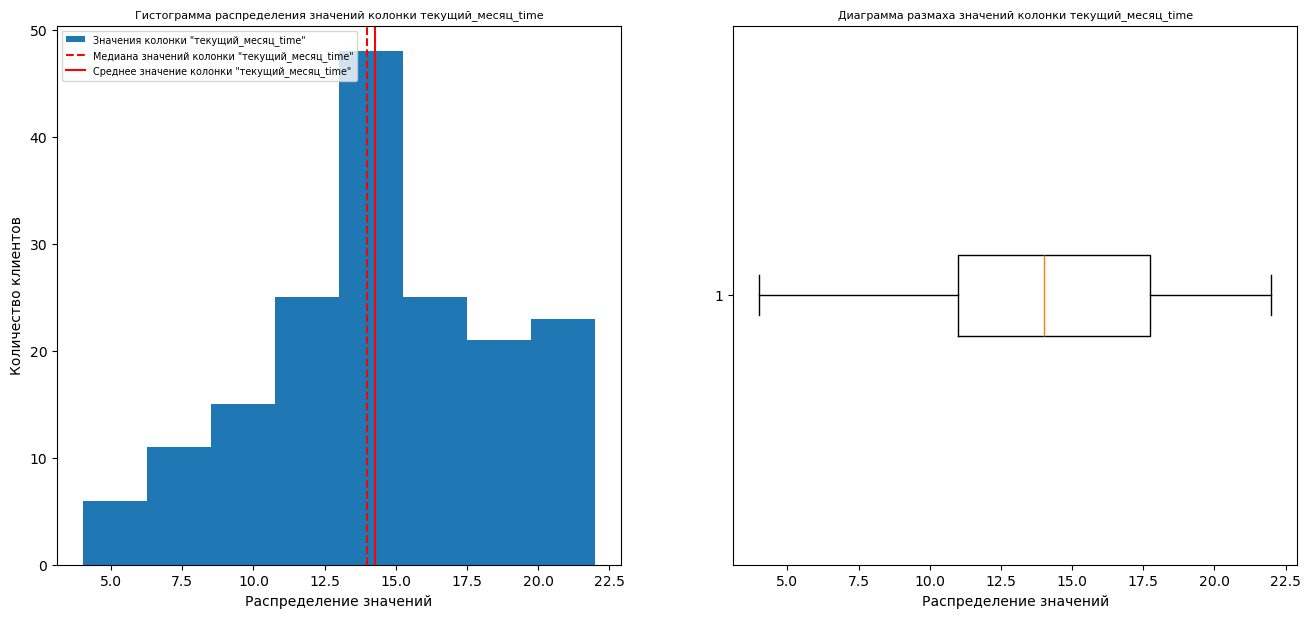

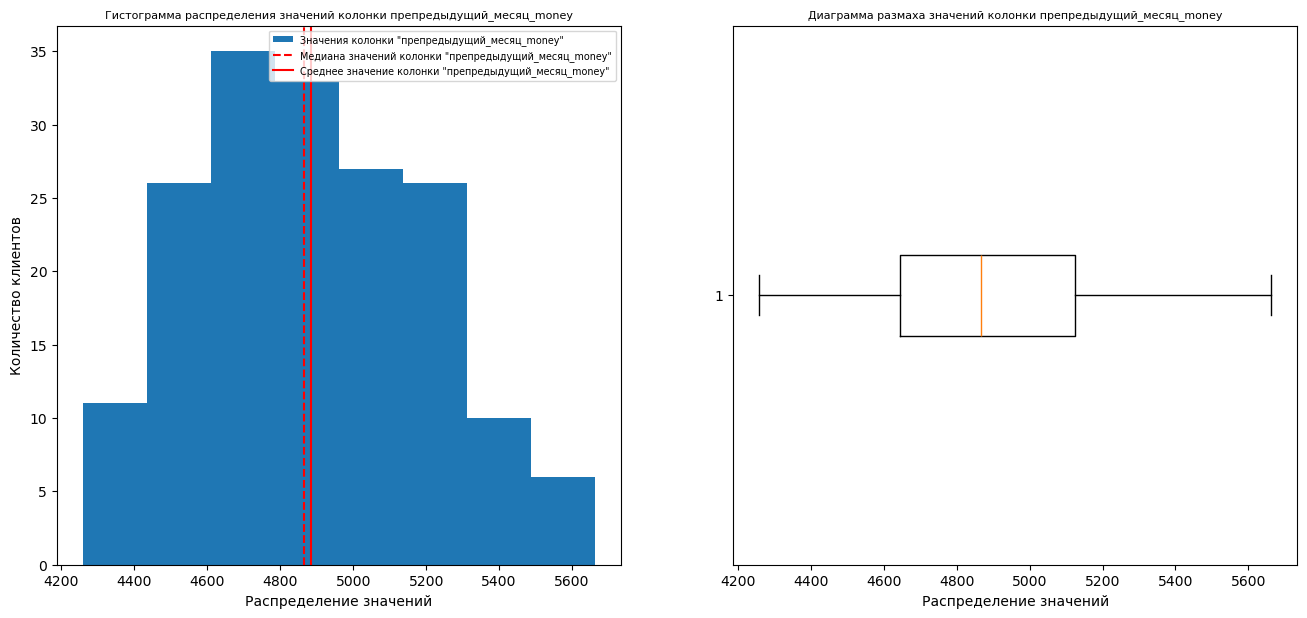

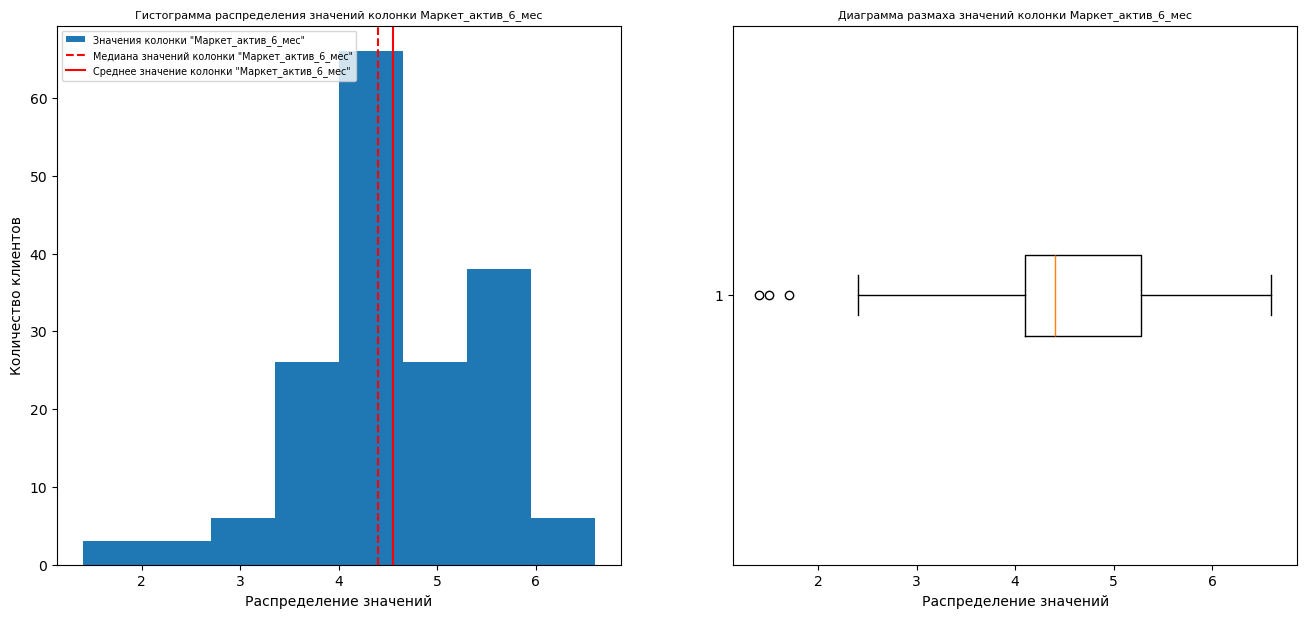

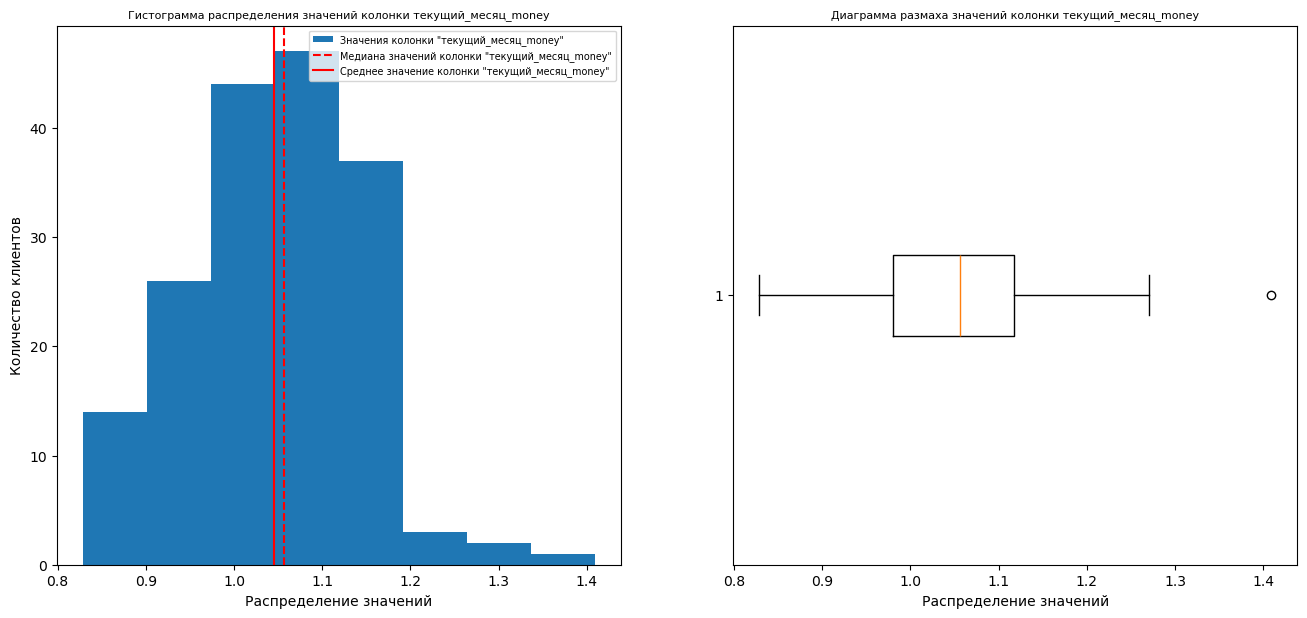

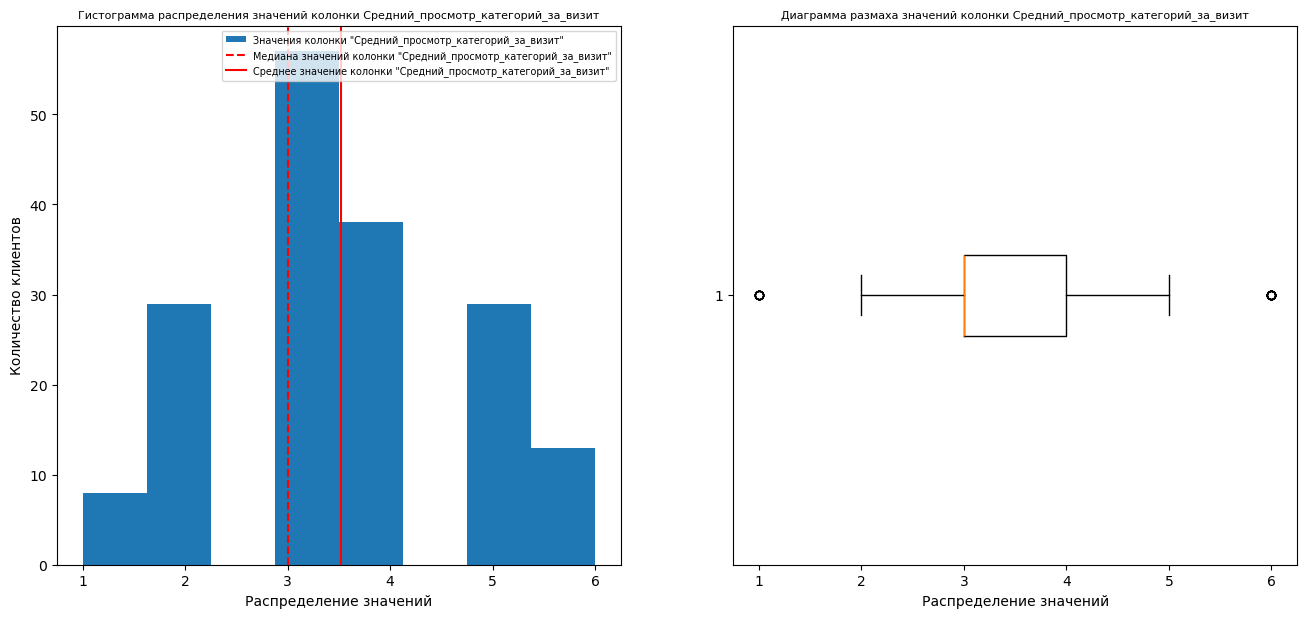

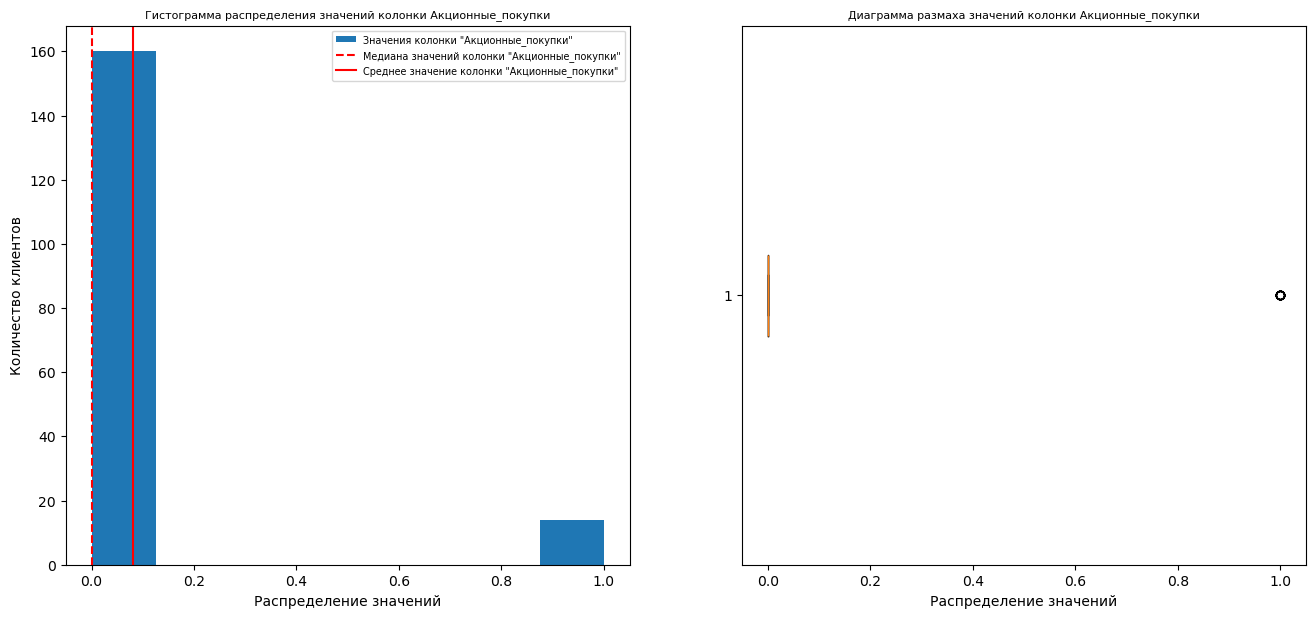

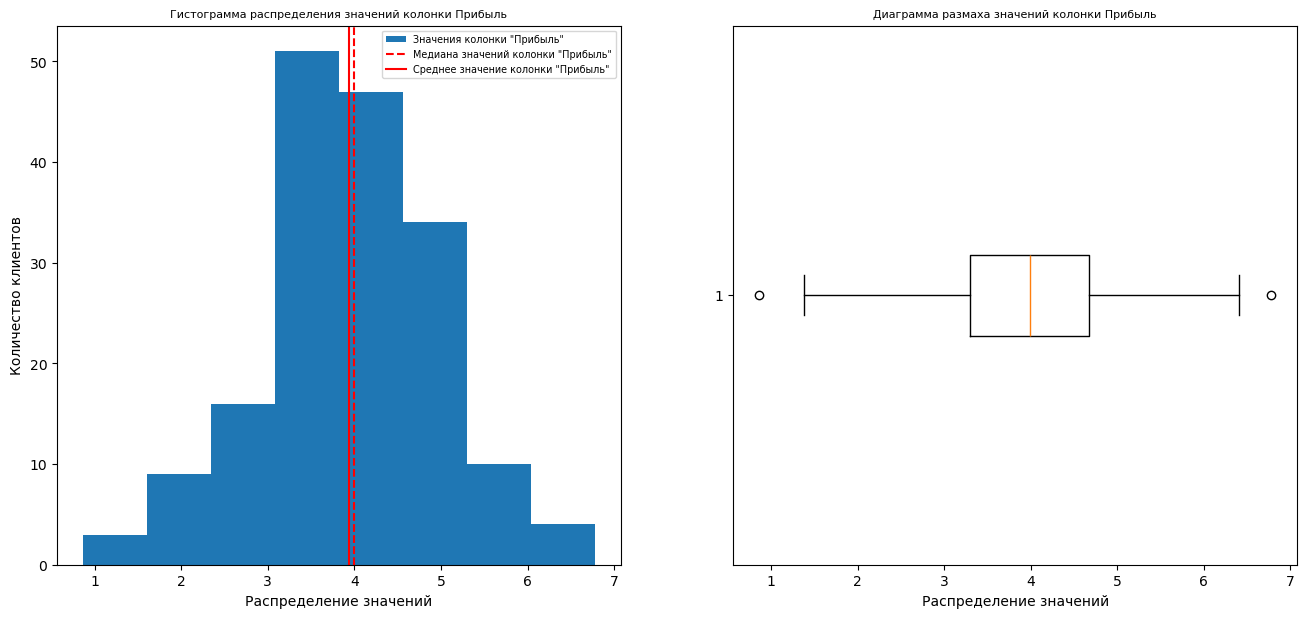

In [61]:
make_plot(group_data[['Страниц_за_визит', 'предыдущий_месяц_time', 'текущий_месяц_time', 'препредыдущий_месяц_money', \
                     'Маркет_актив_6_мес', 'текущий_месяц_money', 'Средний_просмотр_категорий_за_визит', \
                     'Акционные_покупки', 'Прибыль']])

Для увеличения покупательской активности данного сегмента стоит повысить их траты в текущем месяце. Этого можно добиться за счет:
- создания акций/скидок на технику,
- представления большего кол-во товаров данной категории на их страничке сайта
- увеличения контенкстной рекламы

## Общий вывод

В данном проекте требовалось разработать модель, которая позволит предсказать вероятность снижения покупательской активноти клиентов.

Для этого были предоставлены четыре файла. Пропусков в файлах не обнаружено. Были найдены неявные дубликат в файле "market_file.csv" (тип сервиса был прописан с ошибкой). Также признак "акционные покупки" был преобразован в булевый (клиенты, которые чаще покупают по акции и обратная им группа).<br>
Среднестатистический клиент:
- Имеет прежний уровень покупательской активности
- Пользуется стандартным сервисом
- Разрешил сообщения
- Имеет в среднем 4 маркетинговых коммуникации в месяц
- Зарегистрирован около 600 дней на сайте
- Четверть покупок совершает по акциям
- Чаще всего покупает товары для детей
- В среднем смотрит три категории, заходя на сайт
- Имеет 2-3 товара в корзине
- Имел 4 ошибки с сервисом
- Смотрит по 5 товаров в среднем<br>
В среднем выручка сайта увеличиливалась на протящении последних трех месяцев
За текущий месяц компания получила в среднем 5200 с одного клиента

Клиенты стали проводить меньше времени на сайте
В текущем месяце клиент находился на сайте в среднем 13 минут

В среднем магазин получает прибыль в 4 юнита с клиента

Для создания модели был создан пайплайн, отвечающий за предобработку (кодирование/масштабирование) данных и обучение модели. Пайплайн был пропущен через кросс-валидацию случайных наборов параметров.

По итогу кросс-валидации лучшей моделью для оценки метрики recall была отобрана модель DecisionTreeClassifier с глубиной 16, минимум 11 объектов для деления, масштабирвоанием методом RobustScaler количественных признаков

Приметами снижения покупательской активности у клиента можно вынести следующие признаки:
- Малое количество просмотренных за визит страниц
- Малое времяпровождение на сайте
- Низкие траты на покупки
- Малая маркет активность
- Большое число акционных покупок
- Малое число просмотров категорий за визит

В качестве доп анализа был взять сегмент покупателей, покупающих мелкую бытовую технику. Для увеличения покупательской активности данного сегмента стоит повысить их траты в текущем месяце. Этого можно добиться за счет:
- создания акций/скидок на технику,
- представления большего кол-во товаров данной категории на их страничке сайта
- увеличения контенкстной рекламы